In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [396]:
df = pd.read_csv('/Users/malwina.natkaniec/Downloads/anomalies.csv')

In [397]:
df.head()

,sf_name,ReportDay,OX_REVENUE,TOTAL_REQUESTS
0,Zaptush,2021-10-15,755.166910,118761530
1,Marktplaats,2021-10-13,64.049317,103262732
2,Glewed.TV,2021-10-17,13.868833,27070085
3,Eurosport,2021-10-14,60.661932,16802586
4,Weblio,2021-10-15,74.116463,68558805


In [513]:
sf_weekly = df.copy()
# sf_weekly['ReportDay'] = pd.to_datetime(sf_weekly['ReportDay']) - pd.to_timedelta(7, unit='d')
# sf_weekly = sf_weekly.groupby(['sf_name', pd.Grouper(key='ReportDay', freq='W-MON')])['OX_REVENUE'].sum().reset_index().sort_values(['sf_name', 'ReportDay'])

# #removing first week coz of lacking data
# sf_weekly = sf_weekly[sf_weekly['ReportDay']!= "2021-03-15"]
# sf_weekly["OX_REVENUE"] = sf_weekly["OX_REVENUE"].astype(int)
# sf_weekly = sf_weekly.sort_values(by='ReportDay')

sf_weekly["pct_change"] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform(lambda x: x.pct_change()*100).reset_index(0,drop=True)
sf_weekly["diff"] = sf_weekly.groupby('sf_name')['OX_REVENUE'].diff().reset_index(0,drop=True)
sf_weekly["mean"] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform('mean')
sf_weekly["std"] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform('std')
sf_weekly["std_min"] = sf_weekly["mean"]- 3*sf_weekly["std"]
sf_weekly["std_max"] = sf_weekly["mean"]+ 3*sf_weekly["std"]

sf_weekly.loc[(sf_weekly['OX_REVENUE'] >= sf_weekly["std_max"]) | (sf_weekly['OX_REVENUE'] <= sf_weekly["std_min"]), 'is_outlier'] = 1
sf_weekly.loc[(sf_weekly['OX_REVENUE'] > sf_weekly["std_min"]) & (sf_weekly['OX_REVENUE'] < sf_weekly["std_max"]), 'is_outlier'] = 0
sf_weekly["outlier_per_sf"] = sf_weekly.groupby('sf_name')['is_outlier'].transform('sum')

window= 7
rstd_factor = 2
# sf_weekly.set_index('ReportDay')
# sf_weekly['sma'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].rolling(window=window).mean()
sf_weekly['sma'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].rolling(window=window).mean().reset_index(0,drop=True)

sf_weekly['rstd'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].rolling(window=window).std().reset_index(0,drop=True)

sf_weekly.loc[(sf_weekly['OX_REVENUE'] >= sf_weekly["sma"]+ rstd_factor*sf_weekly["rstd"]) | (sf_weekly['OX_REVENUE'] <= (sf_weekly["sma"]- rstd_factor*sf_weekly["rstd"])), 'is_sma_outlier'] = 1
sf_weekly.loc[(sf_weekly['OX_REVENUE'] > sf_weekly["sma"]- rstd_factor*sf_weekly["rstd"]) & (sf_weekly['OX_REVENUE'] < sf_weekly["sma"]+ rstd_factor*sf_weekly["rstd"]), 'is_sma_outlier'] = 0

sf_weekly['mad'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform(lambda x: x.mad())
sf_weekly['median'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform(lambda x: x.median())

sf_weekly['dev'] = np.abs((sf_weekly['OX_REVENUE'] - sf_weekly['median'])/sf_weekly['mad'])
sf_weekly['mad_outlier'] = 0
sf_weekly.loc[sf_weekly['dev'] > 5, 'mad_outlier'] = 1

sf_weekly['ReportDay'] = pd.to_datetime(sf_weekly['ReportDay'])
sf_weekly["weekday_name"] = sf_weekly["ReportDay"].dt.day_name()
sf_weekly["weekday_number"] = sf_weekly["ReportDay"].dt.dayofweek
 

sf_weekly = sf_weekly.round({"pct_change":1, "diff":1, "mean":1, "std":1, "std_min":1, "std_max":1, "median":1, "mad":1})



sf_weekly.head(40)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

,sf_name,ReportDay,OX_REVENUE,TOTAL_REQUESTS,pct_change,diff,mean,std,std_min,std_max,...,outlier_per_sf,sma,rstd,is_sma_outlier,mad,median,dev,mad_outlier,weekday_name,weekday_number
0,Zaptush,2021-10-15,755.166910,118761530,NaN,NaN,945.3,338.8,-71.0,1961.7,...,0.0,NaN,NaN,NaN,264.6,897.2,0.536795,0,Friday,4
1,Marktplaats,2021-10-13,64.049317,103262732,NaN,NaN,40.9,18.6,-14.9,96.7,...,1.0,NaN,NaN,NaN,16.4,31.6,1.978683,0,Wednesday,2
2,Glewed.TV,2021-10-17,13.868833,27070085,NaN,NaN,12.0,12.1,-24.3,48.3,...,5.0,NaN,NaN,NaN,8.5,9.3,0.534926,0,Sunday,6
3,Eurosport,2021-10-14,60.661932,16802586,NaN,NaN,37.1,15.8,-10.2,84.3,...,2.0,NaN,NaN,NaN,12.2,35.4,2.065533,0,Thursday,3
4,Weblio,2021-10-15,74.116463,68558805,NaN,NaN,91.2,25.4,14.9,167.5,...,0.0,NaN,NaN,NaN,20.7,84.9,0.522090,0,Friday,4
5,Mobfox,2021-10-17,67.347358,221089854,NaN,NaN,62.4,30.7,-29.7,154.4,...,1.0,NaN,NaN,NaN,23.6,63.1,0.181493,0,Sunday,6
6,Jappy,2021-10-13,5.191882,1840627,NaN,NaN,4.5,1.6,-0.3,9.3,...,1.0,NaN,NaN,NaN,1.3,4.0,0.952597,0,Wednesday,2
7,Unruly Media,2021-10-12,436.873016,2038306653,NaN,NaN,657.7,274.5,-165.8,1481.3,...,3.0,NaN,NaN,NaN,212.1,596.5,0.752645,0,Tuesday,1
8,RTK.io,2021-10-17,33.529581,8793736,NaN,NaN,161.1,71.7,-54.2,376.3,...,1.0,NaN,NaN,NaN,57.4,164.6,2.282493,0,Sunday,6
9,Time and Date,2021-10-14,156.468869,8418713,NaN,NaN,63.5,33.9,-38.3,165.3,...,1.0,NaN,NaN,NaN,27.2,55.4,3.712846,0,Thursday,3


In [514]:
# sf_weekly['mad'] = sf_weekly.groupby('sf_name')['OX_REVENUE'].transform(lambda x: x.mad())
# sf_weekly['mad'].head()
greetings.head()

,level_0,index,ReportDay,sf_name,OX_REVENUE,TOTAL_REQUESTS,pct_change,diff,mean,std,...,std_max,is_outlier,outlier_per_sf,sma,rstd,is_sma_outlier,mad,median,dev,mad_outlier
0,0,0,2021-03-22,Aller Media Sweden,20.115159,10690935,-69.4,-85.8,19.2,11.5,...,53.6,0.0,10.0,22.524211,16.615954,0.0,7.3,17.2,0.401211,0
1,1,1,2021-03-23,Aller Media Sweden,18.133676,11062820,21.8,0.7,19.2,11.5,...,53.6,0.0,10.0,16.745923,5.777860,0.0,7.3,17.2,0.128420,0
2,2,2,2021-03-24,Aller Media Sweden,12.136172,10055333,-48.7,-11.0,19.2,11.5,...,53.6,0.0,10.0,24.607930,19.124396,0.0,7.3,17.2,0.697258,0
3,3,3,2021-03-25,Aller Media Sweden,13.201121,10055775,227.1,0.0,19.2,11.5,...,53.6,0.0,10.0,16.255962,5.785980,0.0,7.3,17.2,0.550646,0
4,4,4,2021-03-26,Aller Media Sweden,8.728038,10063387,-7.8,-1.7,19.2,11.5,...,53.6,0.0,10.0,20.192567,15.030890,0.0,7.3,17.2,1.166456,0


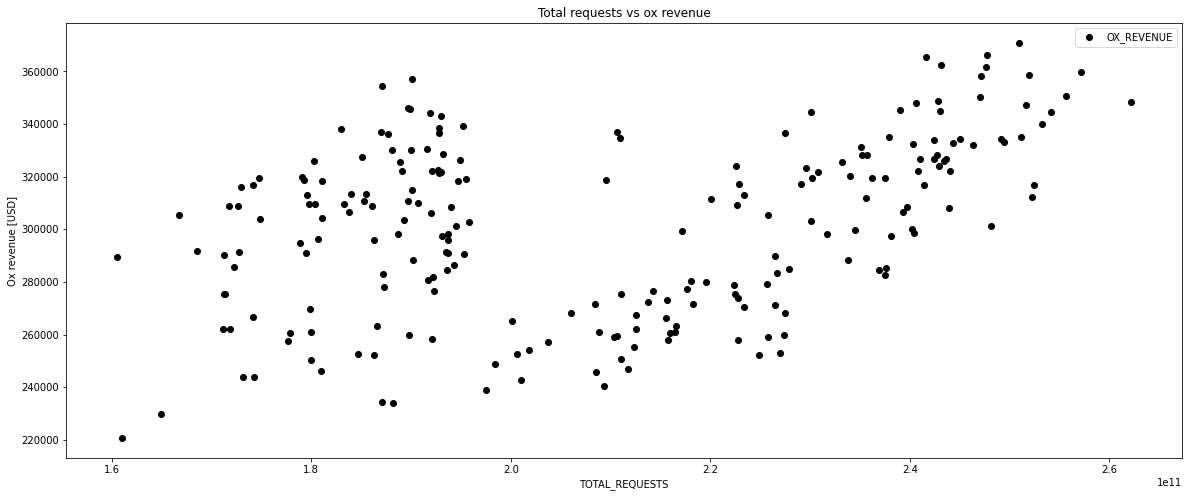

In [515]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(df_daily["TOTAL_REQUESTS"], df_daily['OX_REVENUE'], color='black', label = 'OX_REVENUE')
plt.ylabel("Ox revenue [USD]")
plt.xlabel("TOTAL_REQUESTS")
plt.title("Total requests vs ox revenue")
plt.legend()
plt.show()

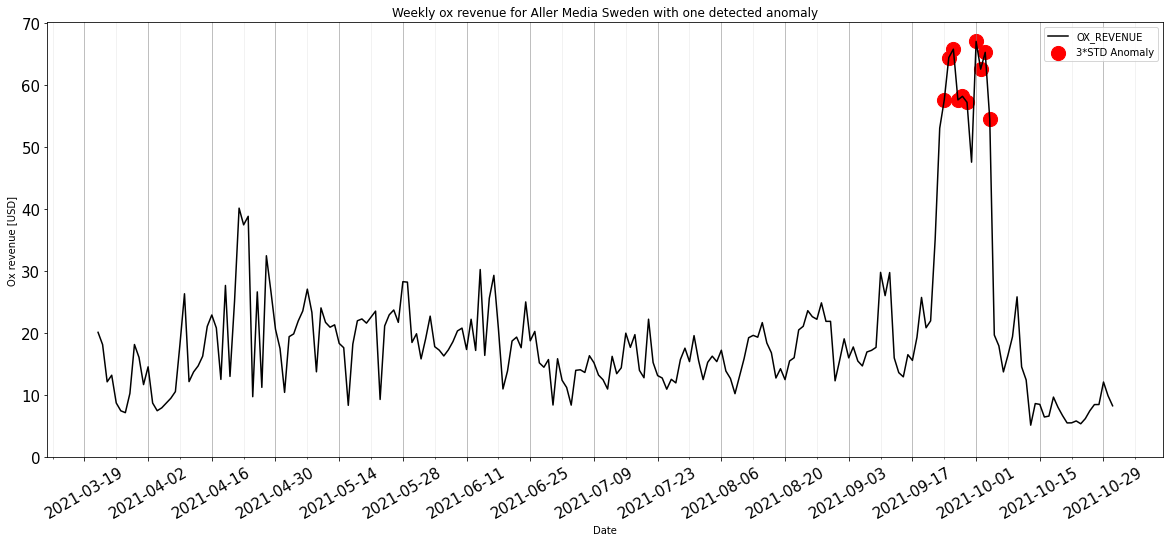

In [516]:
import datetime
fig, ax = plt.subplots(figsize=(20,8))

greetings  = sf_weekly[sf_weekly["sf_name"]=="Aller Media Sweden"]
greetings = greetings.set_index("ReportDay")
greetings.head()
greetings = greetings.sort_values(by='ReportDay')

b = greetings.loc[greetings['is_outlier'] == 1, ['OX_REVENUE']] #anomaly
m = greetings.loc[greetings['mad_outlier'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(greetings.index, greetings['OX_REVENUE'], color='black', label = 'OX_REVENUE')
ax.scatter(b.index,b['OX_REVENUE'], color='red', label = '3*STD Anomaly', s = 200)
# ax.scatter(m.index,m['OX_REVENUE'], color='blue', label = 'MAD Anomaly', s = 300, alpha=0.3)
#annotation
# for i,j in zip(b.index,b['OX_REVENUE']):
#     ax.annotate(str(b.index),xy=(i,j+5))


# ax.text(b.index[1], 90, 'June 7th, June 14th', style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax.set_ylim(ymin=0)
# ax.set_xlim([datetime.date(2021, 3, 15)], [datetime.date(2021, 10, 14)])
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15, rotation=30)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.legend()

ax.xaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.5, which='major')
ax.xaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.1, which='minor')
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.title("Weekly ox revenue for Aller Media Sweden with one detected anomaly")
plt.legend()
plt.show()

In [527]:
greetings.head()

,index,ReportDay,sf_name,OX_REVENUE,TOTAL_REQUESTS,pct_change,diff,mean,std,std_min,...,outlier_per_sf,sma,rstd,is_sma_outlier,mad,median,dev,mad_outlier,weekday_name,weekday_number
0,0,2021-03-22,Aller Media Sweden,20.115159,10690935,-69.4,-85.8,19.2,11.5,-15.1,...,10.0,22.524211,16.615954,0.0,7.3,17.2,0.401211,0,Monday,0
1,1,2021-03-23,Aller Media Sweden,18.133676,11062820,21.8,0.7,19.2,11.5,-15.1,...,10.0,16.745923,5.777860,0.0,7.3,17.2,0.128420,0,Tuesday,1
2,2,2021-03-24,Aller Media Sweden,12.136172,10055333,-48.7,-11.0,19.2,11.5,-15.1,...,10.0,24.607930,19.124396,0.0,7.3,17.2,0.697258,0,Wednesday,2
3,3,2021-03-25,Aller Media Sweden,13.201121,10055775,227.1,0.0,19.2,11.5,-15.1,...,10.0,16.255962,5.785980,0.0,7.3,17.2,0.550646,0,Thursday,3
4,4,2021-03-26,Aller Media Sweden,8.728038,10063387,-7.8,-1.7,19.2,11.5,-15.1,...,10.0,20.192567,15.030890,0.0,7.3,17.2,1.166456,0,Friday,4


In [528]:
def predict_SMA(feature):
  window = 7
  # greetings.reset_index(inplace=True)
  sma = greetings[feature].rolling(window=window).mean()
  rstd = greetings[feature].rolling(window=window).std()
  bands = pd.DataFrame()
  bands['ReportDay']= (greetings['ReportDay']).copy()
  bands['ReportDay'] = pd.to_datetime(bands['ReportDay'], dayfirst=True)
  # f_weekly['ReportDay'] = pd.to_datetime(sf_weekly['ReportDay'])
  bands["weekday_name"] = bands["ReportDay"].dt.day_name()
  bands["weekday_number"] = bands["ReportDay"].dt.dayofweek
  bands['sma'] = sma 
  bands['lower'] = sma - 2 * rstd
  bands['upper'] = sma + 2 * rstd
  bands = bands.join(greetings[feature])
  bands = bands.set_index('ReportDay')
  fig, ax = plt.subplots(figsize=(25,10))
  ax.plot(bands.index, bands['OX_REVENUE'], color='red', label = 'OX_REVENUE')
  ax.plot(bands.index, bands['sma'], color='grey', label = 'SMA')
  ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.2, label = 'STD bands')

  # greetings['Min_SMA']= bands['lower'].copy()
  min_anomaly = bands[bands['OX_REVENUE']<bands['lower']]
  ax.scatter(min_anomaly.index,min_anomaly['OX_REVENUE'], color='red', label = 'Anomaly(-)', s = 100)

  max_anomaly = bands[bands['OX_REVENUE']>bands['upper']]
  ax.scatter(max_anomaly.index,max_anomaly['OX_REVENUE'], color='green', label = 'Anomaly(+)', s = 100)


  ax.set_xlabel('ReportDay')
  ax.set_ylabel(feature)
  ax.set_ylim(ymin=0)


  ticks_to_use = bands.index[::7]
  labels = [ i.strftime("%Y-%m-%d") for i in ticks_to_use ]
  ax.set_xticks(ticks_to_use)
  ax.set_xticklabels(labels)

  
  ax.tick_params(axis='y', which='major', labelsize=15)
  ax.tick_params(axis='x', which='major', labelsize=15, rotation=30)
  ax.grid()
  ax.xaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.5, which='major')
  ax.xaxis.grid(color='gray', linestyle='-', linewidth=1, alpha=0.1, which='minor')


  plt.title("Weekly ox revenue for The App Tower - moving average and std")
  plt.legend()

  plt.show()
  return bands

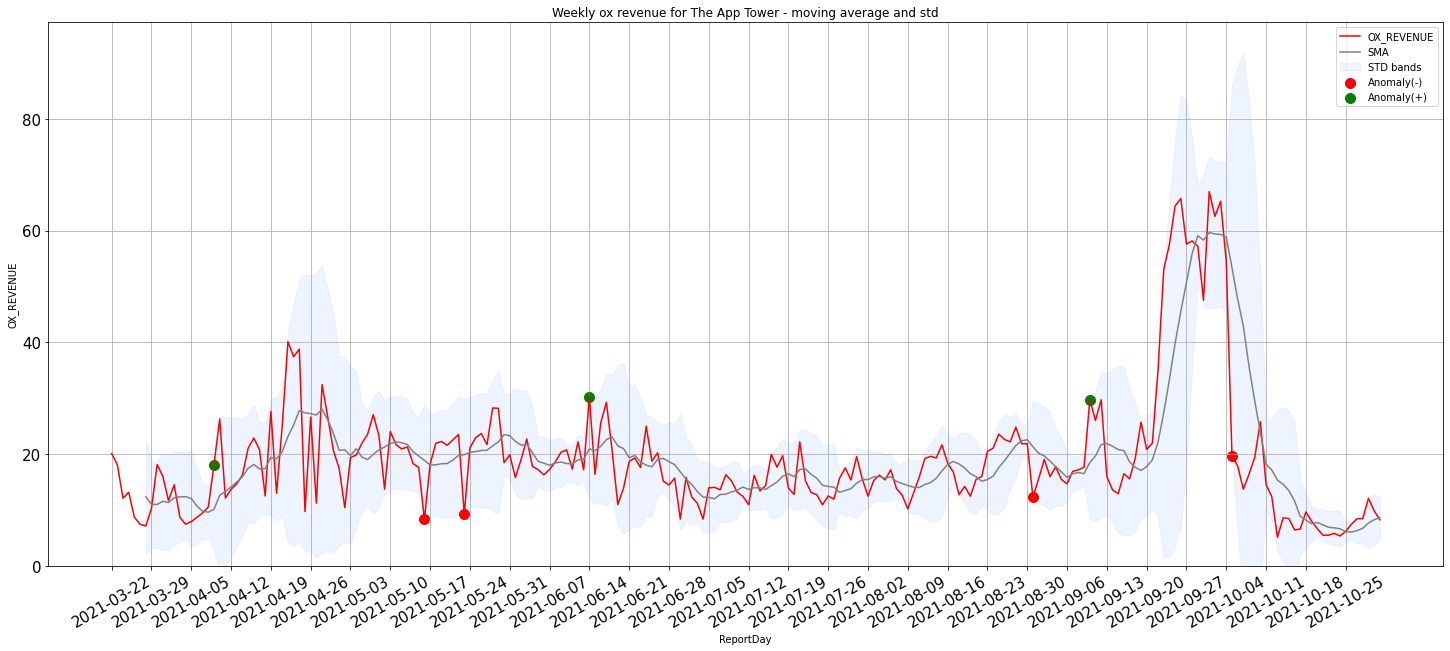

KeyError: "['SMA'] not in index"

In [535]:
# greetings.reset_index(inplace=True)
# del bands
bands = predict_SMA('OX_REVENUE')
bands.reset_index(inplace=True)
# min= greetings['OX_REVENUE']
# bands['lower'].fillna(min , inplace=True)
# greetings['Min_SMA']= bands['lower'].copy()
print('Anamolies for SMA_Min values\n', bands[bands['OX_REVENUE']>bands['upper']][['ReportDay','OX_REVENUE', 'weekday_name']])
# min_anomaly.head()

In [530]:
min_anomaly.head()

,level_0,index,ReportDay,sf_name,OX_REVENUE,pct_change,diff,mean,std,std_min,std_max,is_outlier,outlier_per_sf,SMA,Max_SMA,Min_SMA
8,8,8,2021-05-17,Parential,1225,-48.9,-1171.2,1470.0,857.7,-1103.0,4042.9,0.0,1.0,NaN,2588.361248,1352.759168
9,9,9,2021-05-24,Parential,931,-24.0,-294.4,1470.0,857.7,-1103.0,4042.9,0.0,1.0,NaN,2691.089563,1094.940291
17,17,17,2021-07-19,Parential,939,-20.5,-242.7,1470.0,857.7,-1103.0,4042.9,0.0,1.0,NaN,1639.168800,991.887467
18,18,18,2021-07-26,Parential,709,-24.5,-229.9,1470.0,857.7,-1103.0,4042.9,0.0,1.0,NaN,1442.373314,816.751124
25,25,25,2021-09-13,Parential,1254,-34.4,-657.8,1470.0,857.7,-1103.0,4042.9,0.0,1.0,NaN,3025.166532,1526.888979


<AxesSubplot:title={'center':'Ox_pct change by weekday for Aller Media Sweden'}, xlabel='weekday_name', ylabel='pct_change'>

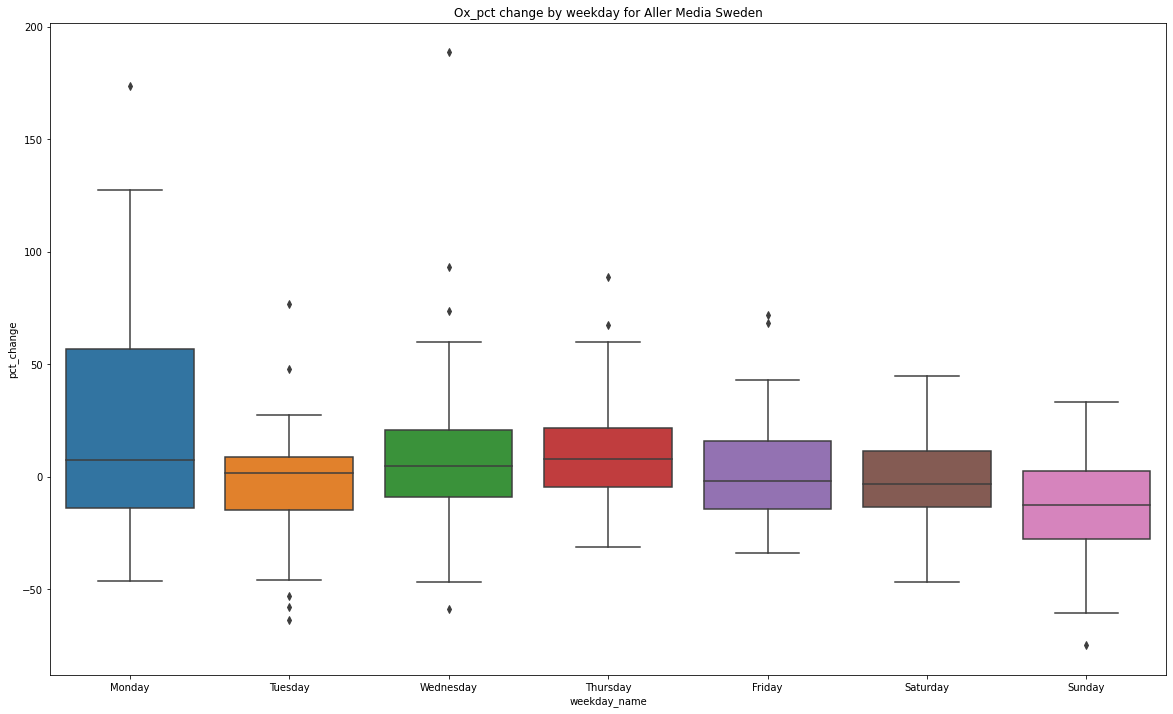

In [488]:
greetings['ReportDay'] = pd.to_datetime(greetings['ReportDay'])
greetings["weekday_name"] = greetings["ReportDay"].dt.day_name()
greetings["weekday_number"] = greetings["ReportDay"].dt.dayofweek

greetings.head()

fig, ax = plt.subplots(figsize=(20, 12))
plt.title("Ox_pct change by weekday for Aller Media Sweden")
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# sns.boxplot(column=['ox_rev_pct_change'], by='weekday_name', ax=ax, order=order)
sns.boxplot(data=greetings, x='weekday_name', y='pct_change', order=order)

<Figure size 1440x432 with 0 Axes>

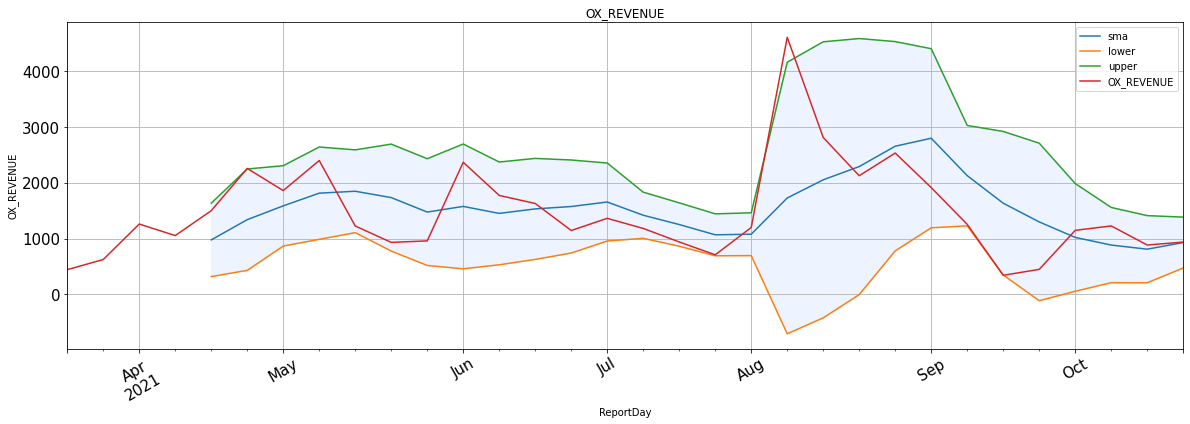

Anamolies for Max_SMA values
     ReportDay  OX_REVENUE      Max_SMA
5  2021-04-26        2255  2245.642601
20 2021-08-09        4604  4157.906669


In [265]:
bands = predict_SMA('OX_REVENUE')
bands.reset_index(inplace=True)
max= greetings['OX_REVENUE'].max()
bands['upper'].fillna(max , inplace=True)

greetings['Max_SMA']= bands['upper'].copy()
print('Anamolies for Max_SMA values\n', greetings[greetings['OX_REVENUE']>greetings['Max_SMA']][['ReportDay','OX_REVENUE', 'Max_SMA']])

Text(0.5, 0, 'Date')

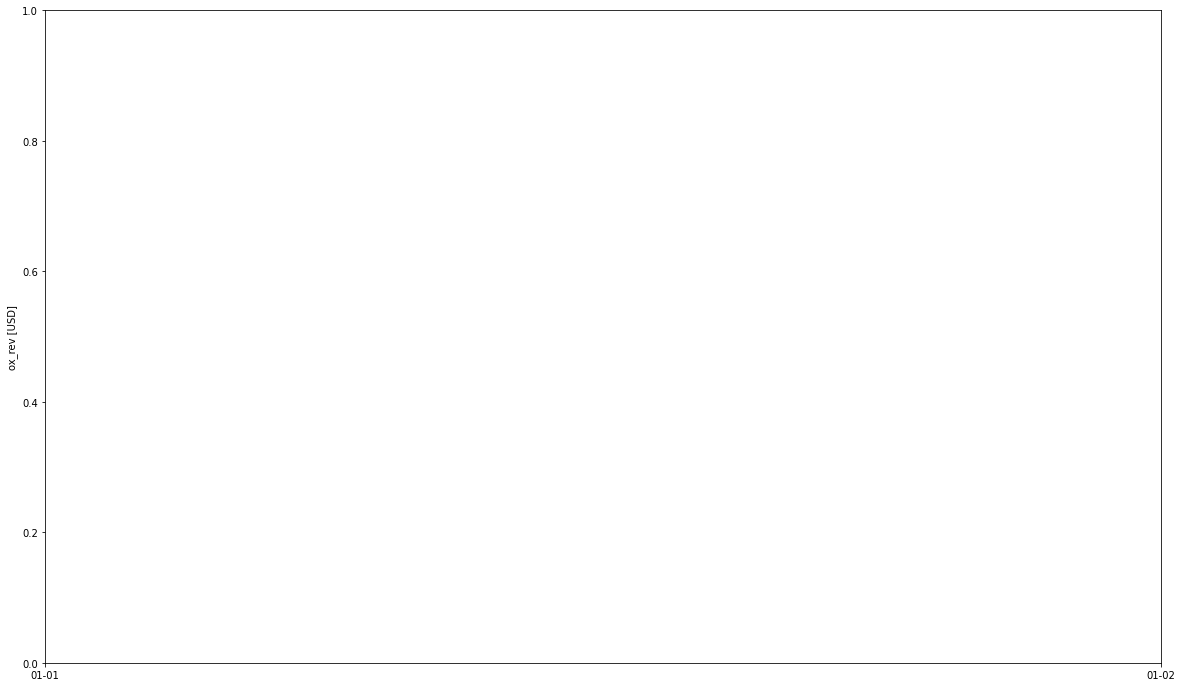

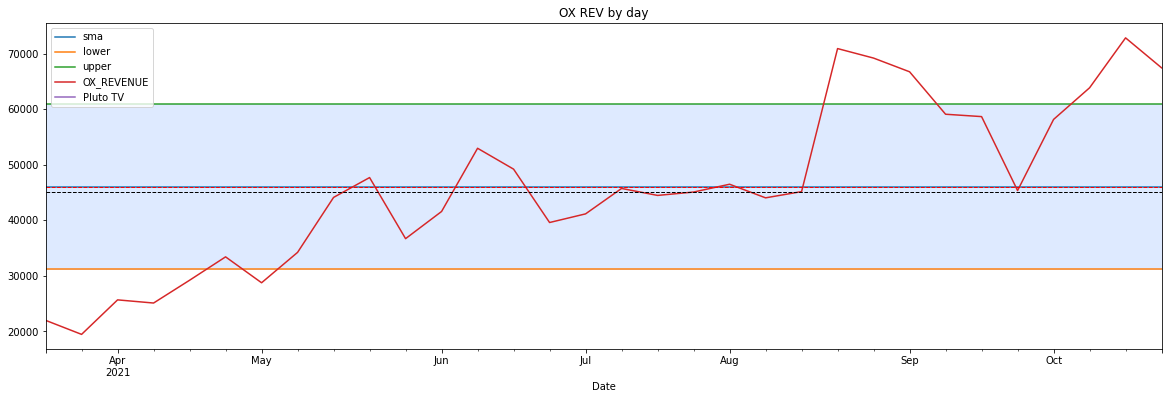

In [119]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("ox_rev [USD]")
# ax2=ax.twinx()
# ax2.set_ylabel("OX_rev taotl [USD]",color="blue",fontsize=14)
# max_xticks = 15
# xloc = plt.MaxNLocator(max_xticks)
# ax.xaxis.set_major_locator(xloc)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.plot('ReportDay', "OX_REVENUE", data=pluto, label="Pluto TV")
# ax.plot('ReportDay', "OX_REVENUE", data=df_yahoo, label="Yahoo")
# ax.plot('ReportDay', "OX_REVENUE", data=df_Primis, label="Primis")
# ax = fig.add_subplot(111)
for i,j,k in zip(pluto['ReportDay'],pluto['OX_REVENUE'],pluto['pct_change']):
    ax.annotate(str(k),xy=(i,j+500))

rstd = pluto['OX_REVENUE'].std()
sma = pluto['OX_REVENUE'].mean()

bands = pd.DataFrame()
bands['ReportDay']= (pluto['ReportDay']).copy()
bands['sma'] = sma
bands['lower'] = sma - 1 * rstd
bands['upper'] = sma + 1 * rstd
bands = bands.join(pluto['OX_REVENUE'])
bands = bands.set_index('ReportDay')
# fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title="feature",  figsize=(20, 6))
ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)



plt.axhline(pluto['OX_REVENUE'].median(), color='k', linestyle='dashed', linewidth=1)
plt.axhline(pluto['OX_REVENUE'].mean(), color='r', linestyle='dashed', linewidth=1)

# in_ylim, max_ylim = plt.ylim()
# plt.text(pluto['OX_REVENUE'].median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(pluto['OX_REVENUE'].median()))
# plt.text(pluto['OX_REVENUE'].mean()*-12.3, max_ylim*0.97, 'Mean: {:.2f}'.format(pluto['OX_REVENUE'].mean()))

plt.legend()
plt.title("OX REV by day")
# plt.ylabel("Ox revenue [USD]")
# plt.setp(plt.gca().xaxis.get_majorticklabels())
plt.xlabel("Date")

TOP MOVERS

In [147]:
sf_weekly_non_zero_rev = sf_weekly[sf_weekly['OX_REVENUE']!=0]

sf_weekly_non_zero_grouped = sf_weekly_non_zero_rev.groupby('sf_name')['outlier_per_sf'].max().reset_index().sort_values(['outlier_per_sf'], ascending=False)
sf_weekly_non_zero_grouped.head(20)
# sf_weekly_non_zero_grouped.nlargest(40, 'outlier_per_sf')



,sf_name,outlier_per_sf
1113,The App Tower,2.0
630,LetsRun,2.0
89,Aller Media Sweden,2.0
395,Freecycle,2.0
1348,finanznachrichten.de,2.0
1105,TeamSnap,2.0
543,Insight,2.0
1,123Greetings,2.0
580,Jorte,1.0
294,Digitalbox Limited,1.0


In [225]:
df_processed = sf_weekly_non_zero_rev[sf_weekly_non_zero_rev['outlier_per_sf']!=0]
df_processed = df_processed[df_processed['is_outlier']!=0]
# df_processed.nsmallest(10, 'pct_change')
df_processed.nlargest(10, 'diff')

,sf_name,ReportDay,OX_REVENUE,pct_change,diff,mean,std,std_min,std_max,is_outlier,outlier_per_sf
33136,Quizlet,2021-09-20,20204,41.2,5893.6,6043.8,4156.2,-6424.9,18512.5,1.0,1.0
11444,E-Planning,2021-10-25,18740,25.5,3810.6,5240.0,4465.5,-8156.4,18636.4,1.0,1.0
43732,Valnet,2021-09-13,10491,48.7,3435.2,5550.4,1563.2,860.8,10240.0,1.0,1.0
12800,Ex Co,2021-06-21,14696,30.5,3434.2,7252.3,2431.6,-42.5,14547.2,1.0,1.0
30668,Parential,2021-08-09,4604,284.2,3405.9,1470.0,857.7,-1103.0,4042.9,1.0,1.0
1573,AdAlliance,2021-07-05,7155,74.5,3054.9,2383.5,1069.1,-823.6,5590.7,1.0,1.0
33955,Rebecca Digital Media,2021-07-12,12664,30.8,2984.6,2645.5,3148.3,-6799.3,12090.4,1.0,1.0
17705,Hearst Magazines,2021-09-13,8139,53.6,2841.4,3739.1,1377.7,-394.1,7872.3,1.0,1.0
12313,Enthusiast Gaming,2021-05-24,8425,49.1,2776.2,4267.5,1207.1,646.2,7888.8,1.0,1.0
8387,Complex,2021-05-24,3517,269.3,2564.9,1060.2,537.5,-552.4,2672.7,1.0,1.0


In [72]:
sf_weekly.nlargest(10, 'diff')

,sf_name,ReportDay,OX_REVENUE,pct_change,diff
31707,Pluto TV,2021-08-23,70894,57.0,25741.9
46730,Yahoo,2021-08-16,134705,19.8,22292.1
19413,Inneractive,2021-04-05,28947,195.8,19161.9
25142,Mediavine,2021-04-12,69372,34.9,17930.6
32375,Primis,2021-05-24,84485,26.8,17849.4
46739,Yahoo,2021-10-18,142556,13.5,16916.6
32396,Primis,2021-10-18,83133,25.3,16768.3
46713,Yahoo,2021-04-19,217292,8.2,16556.0
25151,Mediavine,2021-06-14,110131,17.5,16373.4
37035,Smaato,2021-04-26,39348,71.2,16362.3


In [50]:
sf_weekly = sf_weekly[sf_weekly['ReportDay']!= "2021-03-15"]
sf_weekly.head()

,sf_name,ReportDay,OX_REVENUE,pct_ch
1,10up,2021-03-22,144,9.510368
2,10up,2021-03-29,140,0.972597
3,10up,2021-04-05,228,1.622772
4,10up,2021-04-12,308,1.351803
5,10up,2021-04-19,296,0.958411


In [148]:
# df['ReportDay'].unique()

In [10]:
df_daily = df.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()
df_daily.head()

,ReportDay,OX_REVENUE
0,2021-03-22,319975.713148
1,2021-03-23,309772.757151
2,2021-03-24,309695.643616
3,2021-03-25,318577.621975
4,2021-03-26,316761.899430


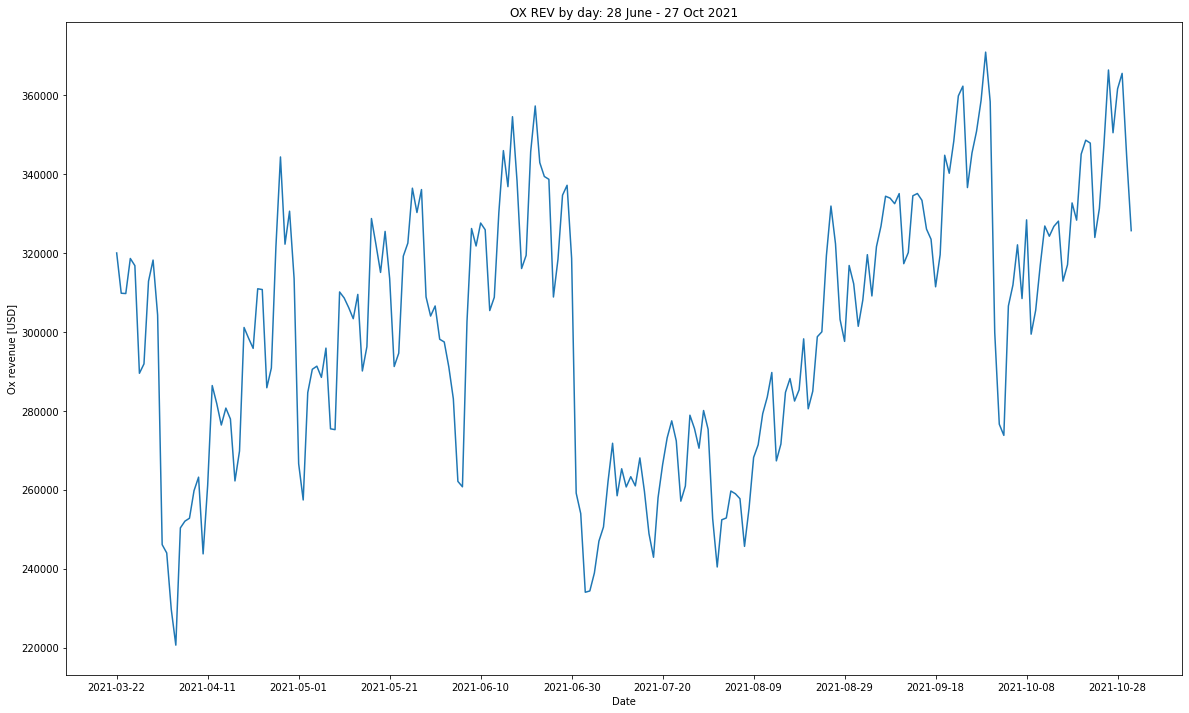

In [11]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("OX REV by day: 28 June - 27 Oct 2021")
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.plot('ReportDay', "OX_REVENUE", data=df_daily)


In [150]:
# fig = plt.figure(figsize=(20, 12))
# max_xticks = 15
# xloc = plt.MaxNLocator(max_xticks)
# ax.xaxis.set_major_locator(xloc)
# plt.title("Histogram ox revenue daily")

# num_bins = 15

# plt.xlabel("Ox revenue [USD]")
# plt.hist(df_daily["OX_REVENUE"], num_bins, facecolor='blue', alpha=0.5)


In [13]:
df_sf = df.groupby(["sf_name"])["OX_REVENUE"].sum().reset_index()
df_sf.sort_values(["OX_REVENUE"] ,ascending=False).head()

,sf_name,OX_REVENUE
1593,Yahoo,4.822923e+06
856,Mediavine,2.558955e+06
1103,Primis,1.847824e+06
1462,Undertone,1.692464e+06
1245,ShareThrough,1.664040e+06


In [14]:
df_mediavine = df[df["sf_name"]=="Mediavine"]
df_mediavine = df_mediavine.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_yahoo = df[df["sf_name"]=="Yahoo"]
df_yahoo = df_yahoo.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_Primis= df[df["sf_name"]=="Primis"]
df_Primis = df_Primis.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()

df_Primis.head()

,ReportDay,OX_REVENUE
0,2021-03-22,6621.127050
1,2021-03-23,6552.133527
2,2021-03-24,7009.734239
3,2021-03-25,7499.312888
4,2021-03-26,8535.121475


Text(0.5, 0, 'Date')

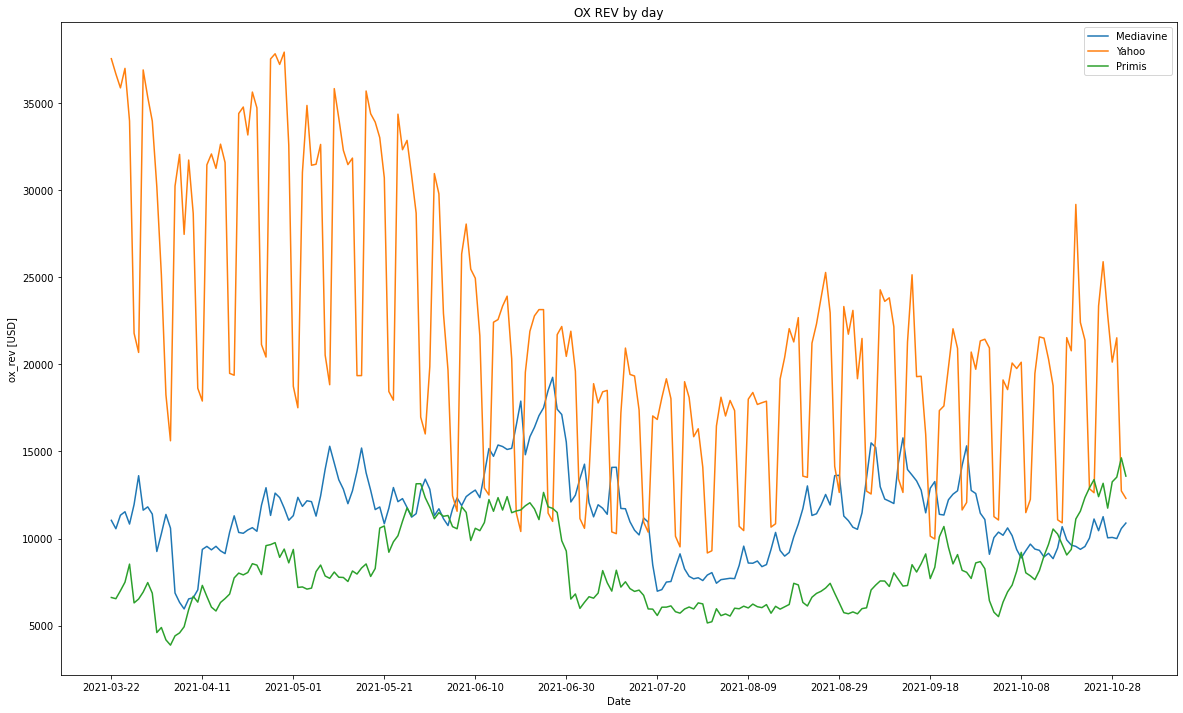

In [15]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("ox_rev [USD]")
# ax2=ax.twinx()
# ax2.set_ylabel("OX_rev taotl [USD]",color="blue",fontsize=14)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

ax.plot('ReportDay', "OX_REVENUE", data=df_mediavine, label="Mediavine")
ax.plot('ReportDay', "OX_REVENUE", data=df_yahoo, label="Yahoo")
ax.plot('ReportDay', "OX_REVENUE", data=df_Primis, label="Primis")

plt.legend()
plt.title("OX REV by day")
# plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")

Text(0.5, 0, 'Ox revenue [USD]')

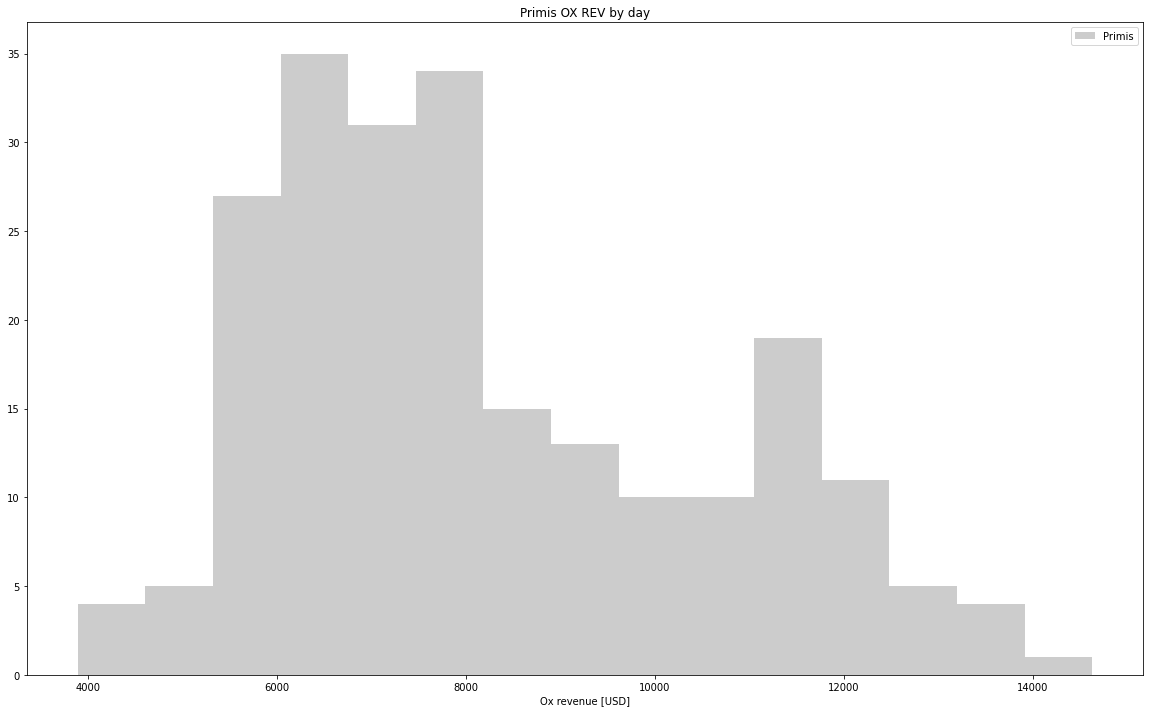

In [16]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue daily")

num_bins = 15

plt.xlabel("Ox revenue [USD]")

# plt.hist( df_mediavine["OX_REVENUE"],num_bins, label="Mediavine", alpha=0.4)
# plt.hist( df_yahoo["OX_REVENUE"], num_bins,label="Yahoo", color="green", alpha=0.4)
plt.hist(df_Primis["OX_REVENUE"], num_bins, label="Primis", color="gray", alpha=0.4)

plt.legend()
plt.title("Primis OX REV by day")
plt.xlabel("Ox revenue [USD]")

In [17]:
daily_median = df_daily["OX_REVENUE"].median()
daily_25p, daily_75p = df_daily["OX_REVENUE"].quantile(0.25), df_daily["OX_REVENUE"].quantile(0.75)
daily_iqr = daily_75p - daily_25p
daily_lower_band = daily_25p - 1.5*daily_iqr
daily_upper_band = daily_75p + 1.5*daily_iqr

daily_median, daily_25p, daily_75p, daily_lower_band, daily_upper_band
df_daily["OX_REVENUE"].min(), df_daily["OX_REVENUE"].max()

(220636.928199, 370842.313853)

In [18]:
df_daily_outliers = df_daily[(df_daily["OX_REVENUE"]<daily_lower_band) | (df_daily["OX_REVENUE"]>daily_upper_band)]
df_daily_outliers.head()

,ReportDay,OX_REVENUE


In [19]:
df_daily['Date'] = pd.to_datetime(df_daily['ReportDay']) - pd.to_timedelta(7, unit='d')
df_weekly = df_daily.groupby([pd.Grouper(key='Date', freq='W-MON')])['OX_REVENUE'].sum().reset_index().sort_values('Date')

# df.groupby(["ReportDay"])["OX_REVENUE"].sum().reset_index()
df_daily.head(20)

,ReportDay,OX_REVENUE,Date
0,2021-03-22,319975.713148,2021-03-15
1,2021-03-23,309772.757151,2021-03-16
2,2021-03-24,309695.643616,2021-03-17
3,2021-03-25,318577.621975,2021-03-18
4,2021-03-26,316761.899430,2021-03-19
5,2021-03-27,289497.707829,2021-03-20
6,2021-03-28,291878.887444,2021-03-21
7,2021-03-29,312823.594094,2021-03-22
8,2021-03-30,318174.951614,2021-03-23
9,2021-03-31,304245.578974,2021-03-24


In [36]:
df_weekly.head()

,Date,OX_REVENUE
0,2021-03-15,3.199757e+05
1,2021-03-22,2.149008e+06
2,2021-03-29,1.813151e+06
3,2021-04-05,1.819026e+06
4,2021-04-12,1.949932e+06


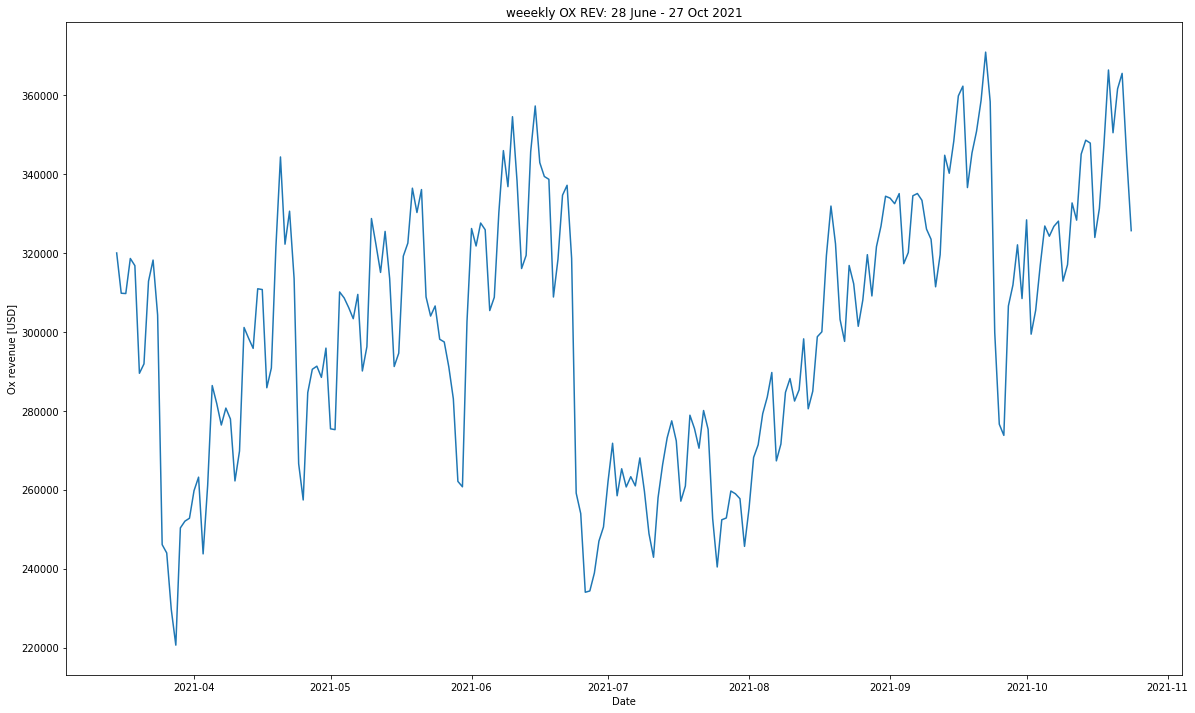

In [20]:
ig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
max_xticks = 15
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("weeekly OX REV: 28 June - 27 Oct 2021")
plt.ylabel("Ox revenue [USD]")
plt.xlabel("Date")
plt.plot('Date', "OX_REVENUE", data=df_daily)

In [21]:

# df_daily = df_daily.drop(columns=["Date"])
df_daily['ox_rev_pct_change'] = df_daily["OX_REVENUE"].pct_change()*100
df_daily = df_daily.round({"ox_rev_pct_change":1})
df_daily["OX_REVENUE"] = df_daily["OX_REVENUE"].astype(int)
df_daily.head(20)

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change
0,2021-03-22,319975,2021-03-15,NaN
1,2021-03-23,309772,2021-03-16,-3.2
2,2021-03-24,309695,2021-03-17,-0.0
3,2021-03-25,318577,2021-03-18,2.9
4,2021-03-26,316761,2021-03-19,-0.6
5,2021-03-27,289497,2021-03-20,-8.6
6,2021-03-28,291878,2021-03-21,0.8
7,2021-03-29,312823,2021-03-22,7.2
8,2021-03-30,318174,2021-03-23,1.7
9,2021-03-31,304245,2021-03-24,-4.4


In [22]:
df_daily['anomaly'] = 0
df_daily.loc[df_daily['ox_rev_pct_change'] > 16, 'anomaly'] = 1
df_daily.loc[df_daily['ox_rev_pct_change'] < -14.6, 'anomaly'] = -1
mad  = df_daily['OX_REVENUE'].mad()
median = df_daily['OX_REVENUE'].median()

df_daily['dev'] = np.abs((df_daily['OX_REVENUE'] - median)/mad)
df_daily['mad_outlier'] = 0
df_daily.loc[df_daily['dev'] > 2.3, 'mad_outlier'] = 1
df_daily['mad_outlier'].sum()
# df_daily['mad_outlier'] = df_daily[df_daily["dev"]>2]



    # median = np.median(points, axis=0)
    # diff = np.sum((points - median)**2, axis=-1)
    # diff = np.sqrt(diff)
    # med_abs_deviation = np.median(diff)

    # modified_z_score = 0.6745 * diff / med_abs_deviation


df_daily.head()

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change,anomaly,dev,mad_outlier
0,2021-03-22,319975,2021-03-15,NaN,0,0.508411,0
1,2021-03-23,309772,2021-03-16,-3.2,0,0.142514,0
2,2021-03-24,309695,2021-03-17,-0.0,0,0.139753,0
3,2021-03-25,318577,2021-03-18,2.9,0,0.458276,0
4,2021-03-26,316761,2021-03-19,-0.6,0,0.393152,0


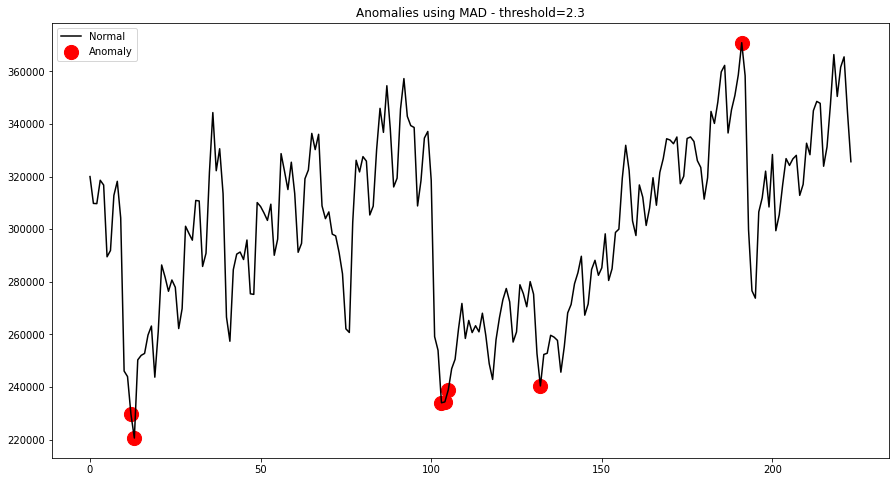

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
a = df_daily.loc[df_daily['anomaly'] == -1, ['OX_REVENUE']] #anomaly
# b = df_daily.loc[df_daily['anomaly'] == 1, ['OX_REVENUE']] #anomaly
b = df_daily.loc[df_daily['mad_outlier'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(df_daily.index, df_daily['OX_REVENUE'], color='black', label = 'Normal')
# ax.scatter(a.index,a['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
ax.scatter(b.index,b['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
plt.legend()
plt.title("Anomalies using MAD - threshold=2.3")
plt.show()

Text(-1.7208968609865458, 41.7585, 'Mean: 0.14')

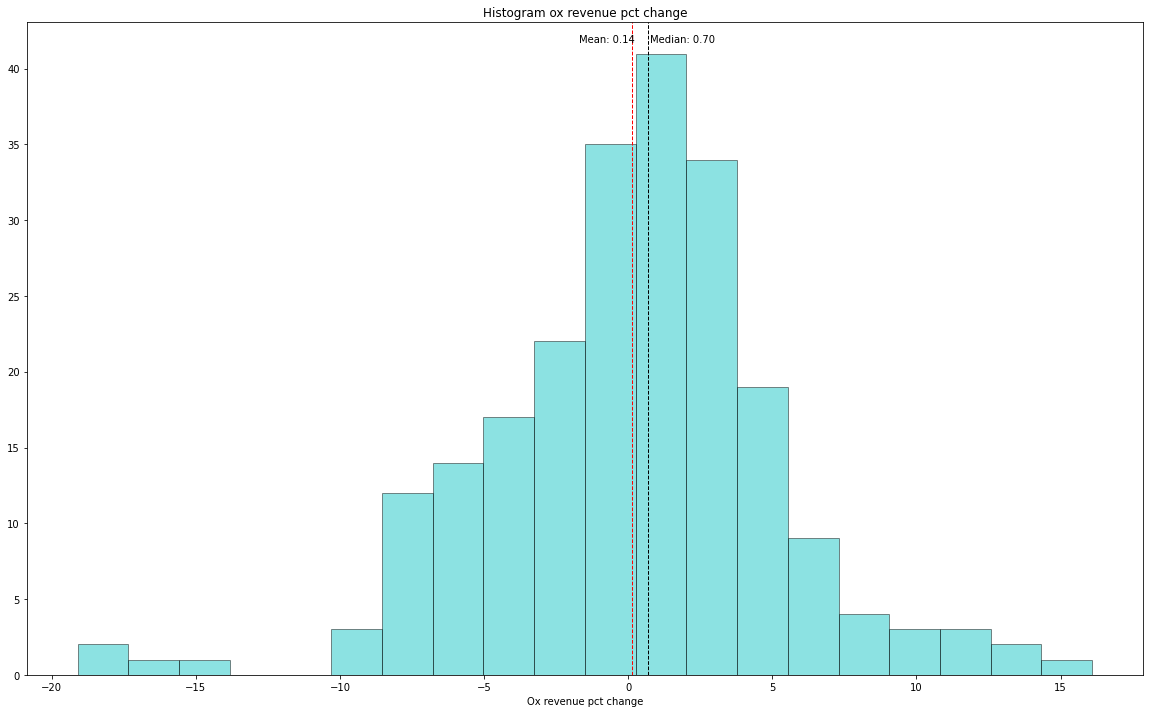

In [24]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change")

num_bins = 15

plt.xlabel("Ox revenue pct change")
x= df_daily["ox_rev_pct_change"]
result = plt.hist(x, bins=20, color='c', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-12.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))
# plt.hist(df_daily["ox_rev_pct_change"], num_bins, alpha=0.5)

In [25]:
x.median() - 3*x.std(), x.median() + 3*x.std()

(-14.620726287658027, 16.020726287658025)

In [26]:
df_daily['ReportDay'] = pd.to_datetime(df_daily['ReportDay'])

df_daily_july = df_daily[df_daily['ReportDay'].dt.month == 7]
df_daily_august = df_daily[df_daily['ReportDay'].dt.month == 8]
df_daily_september = df_daily[df_daily['ReportDay'].dt.month == 9]

df_daily_july

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change,anomaly,dev,mad_outlier
101,2021-07-01,259151,2021-06-24,-18.7,-1,1.672840,0
102,2021-07-02,253966,2021-06-25,-2.0,0,1.858783,0
103,2021-07-03,234035,2021-06-26,-7.8,0,2.573542,1
104,2021-07-04,234364,2021-06-27,0.1,0,2.561744,1
105,2021-07-05,238904,2021-06-28,1.9,0,2.398932,1
106,2021-07-06,246994,2021-06-29,3.4,0,2.108811,0
107,2021-07-07,250560,2021-06-30,1.4,0,1.980928,0
108,2021-07-08,262085,2021-07-01,4.6,0,1.567622,0
109,2021-07-09,271776,2021-07-02,3.7,0,1.220086,0
110,2021-07-10,258475,2021-07-03,-4.9,0,1.697083,0


Text(-2.043870967741936, 6.111, 'Mean: -0.62')

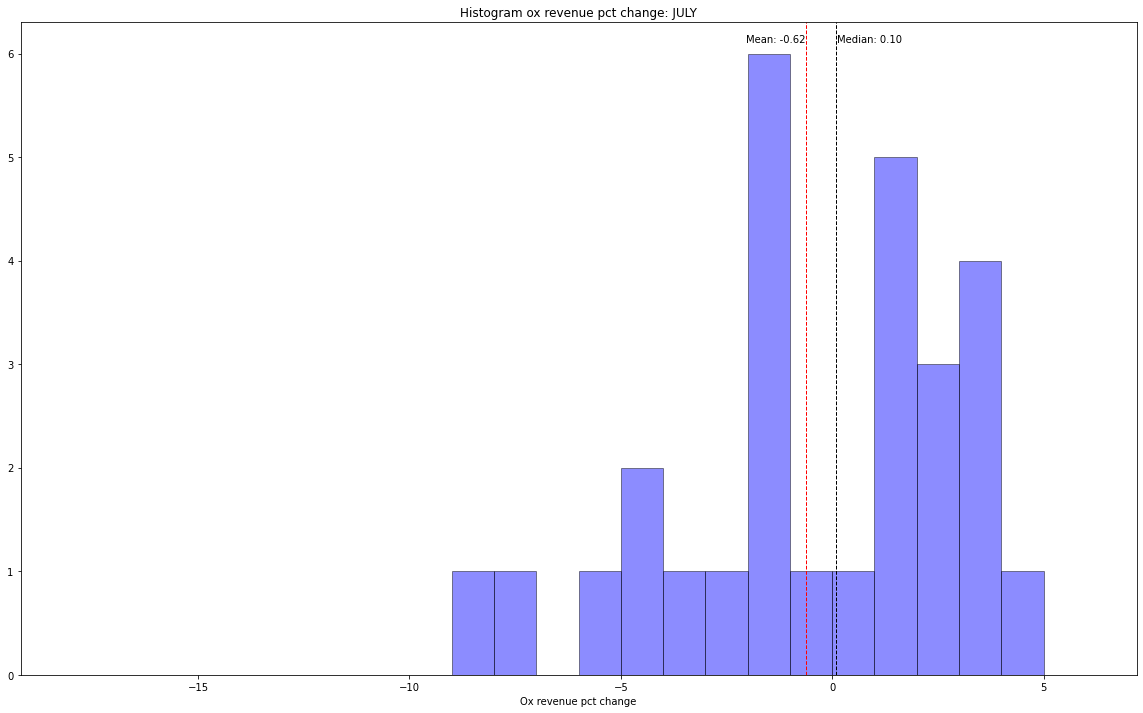

In [27]:
ig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: JULY")

# num_bins = 20
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_july["ox_rev_pct_change"]
# result = plt.hist(x, bins=20, color='b', edgecolor='k', alpha=0.45)
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='b', edgecolor='k', alpha=0.45)

plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*3.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

Text(-0.22548387096774192, 6.111, 'Mean: 0.75')

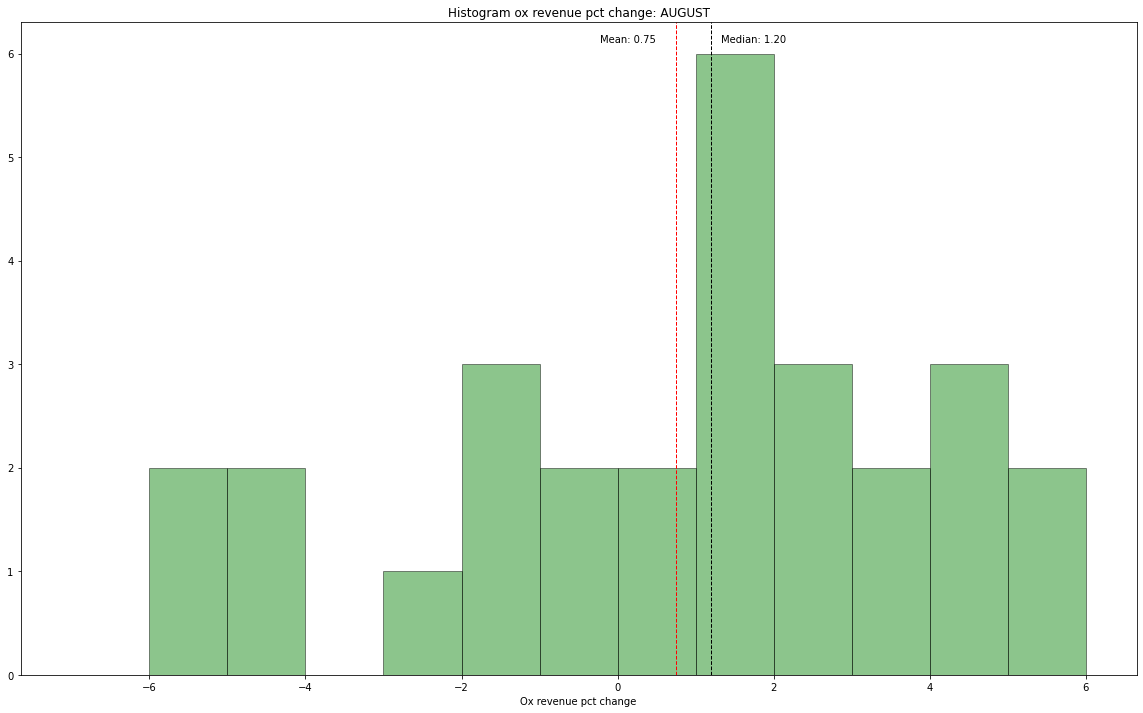

In [28]:
ig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: AUGUST")

# num_bins = 15
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_august["ox_rev_pct_change"]
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='g', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-0.3, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

Text(-0.4619999999999999, 6.111, 'Mean: 0.51')

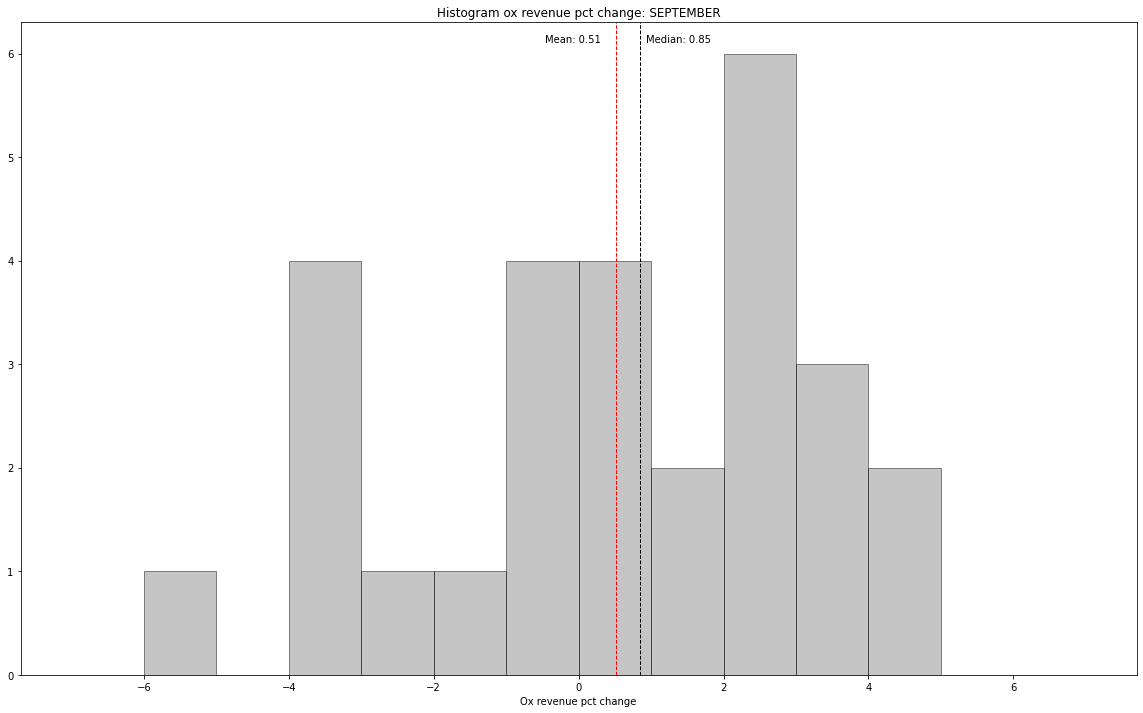

In [29]:
fig = plt.figure(figsize=(20, 12))
max_xticks = 25
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
plt.title("Histogram ox revenue pct change: SEPTEMBER")

# num_bins = 15
binwidth=1

plt.xlabel("Ox revenue pct change")
x= df_daily_september["ox_rev_pct_change"]
result = plt.hist(x, bins=np.arange(int(min(x)), int(max(x)) + binwidth, binwidth), color='grey', edgecolor='k', alpha=0.45)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=1)
in_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.97, 'Median: {:.2f}'.format(x.median()))
plt.text(x.mean()*-0.9, max_ylim*0.97, 'Mean: {:.2f}'.format(x.mean()))

In [30]:
df_daily["weekday_name"] = df_daily["ReportDay"].dt.day_name()
df_daily["weekday_number"] = df_daily["ReportDay"].dt.dayofweek

df_daily.head()

,ReportDay,OX_REVENUE,Date,ox_rev_pct_change,anomaly,dev,mad_outlier,weekday_name,weekday_number
0,2021-03-22,319975,2021-03-15,NaN,0,0.508411,0,Monday,0
1,2021-03-23,309772,2021-03-16,-3.2,0,0.142514,0,Tuesday,1
2,2021-03-24,309695,2021-03-17,-0.0,0,0.139753,0,Wednesday,2
3,2021-03-25,318577,2021-03-18,2.9,0,0.458276,0,Thursday,3
4,2021-03-26,316761,2021-03-19,-0.6,0,0.393152,0,Friday,4


In [481]:
df_daily["ReportDay"] = pd.to_datetime(df_daily["ReportDay"])
df_daily['day'] = df_daily["ReportDay"].dt.day 
df_daily.head()

,ReportDay,OX_REVENUE,TOTAL_REQUESTS,day
0,2021-03-22,319975.713148,179091656871,22
1,2021-03-23,309772.757151,179792147182,23
2,2021-03-24,309695.643616,180407115016,24
3,2021-03-25,318577.621975,179239097871,25
4,2021-03-26,316761.899430,174178695574,26


In [483]:
sns.boxplot(data=df_daily, x='day', y='pct_change')

ValueError: Could not interpret input 'pct_change'

In [480]:
df_first_day = df_daily[(df_daily['day'] == 1 )]
df_first_day = df_first_day[['ReportDay', "OX_REVENUE", 'ox_rev_pct_change', 'anomaly']]
df_first_day.head(10)

KeyError: "['ox_rev_pct_change', 'anomaly'] not in index"

ValueError: Could not interpret input 'weekday_name'

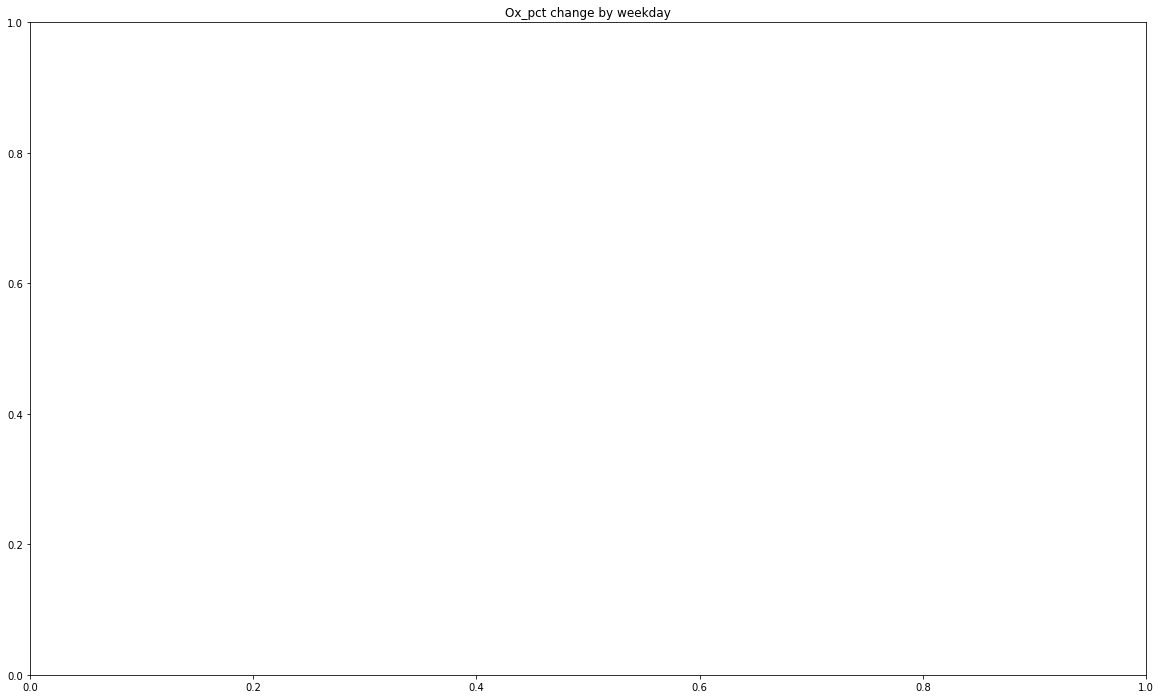

In [477]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.title("Ox_pct change by weekday")
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# sns.boxplot(column=['ox_rev_pct_change'], by='weekday_name', ax=ax, order=order)
sns.boxplot(data=df_daily, x='weekday_name', y='ox_rev_pct_change', order=order)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: 'anomaly1'

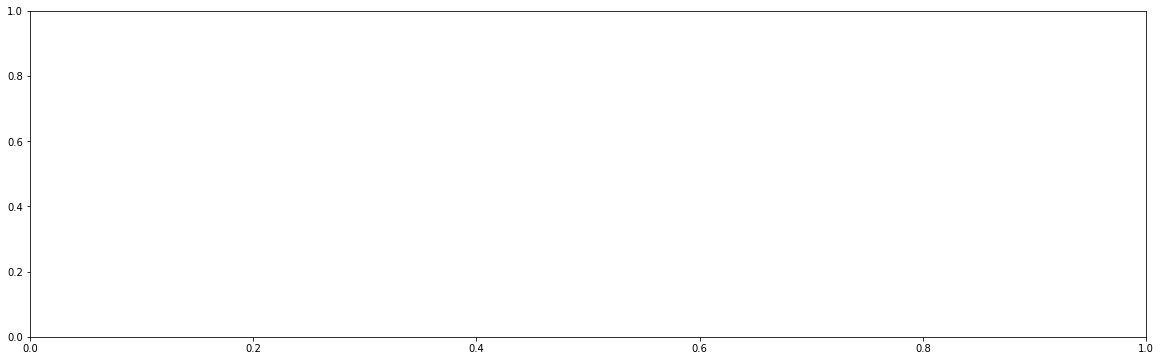

In [35]:
df = df.sort_values('ReportDay')
df["date_time"] = pd.to_datetime(df["ReportDay"])
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(20,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'OX_REVENUE']] #anomaly

ax.scatter(a['date_time_int'],a['OX_REVENUE'], color='red', label='Anomaly',s = 200)
ax.plot(df['date_time_int'], df['OX_REVENUE'], color='blue', label='Normal',linewidth=0.7)
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

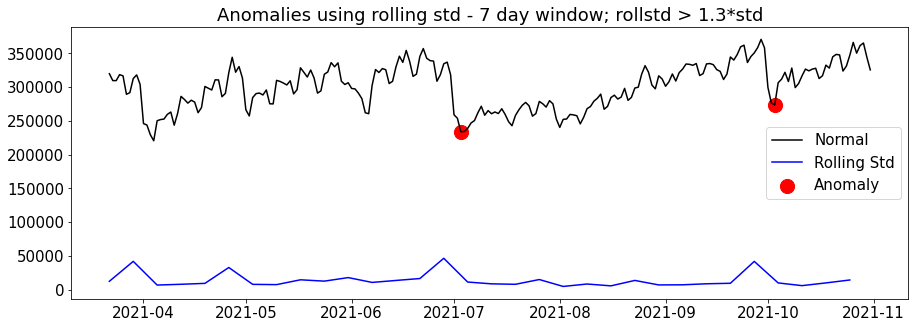

In [ ]:
df_daily['ReportDay'] = pd.to_datetime(df_daily['ReportDay'])
df_test = df_daily[['ReportDay', 'OX_REVENUE', 'TOTAL_REQUESTS']]
df_test = df_test.set_index('ReportDay')
df_test.head()

df_test['rollmean'] = df_test["OX_REVENUE"].rolling(5).mean()
df_test['rollstd'] = df_test["OX_REVENUE"].rolling(5).std()


df_test['std_outlier'] = 0
std = df_test["OX_REVENUE"].std()
df_test.loc[df_test['rollstd'] > 1.3*std, 'std_outlier'] = 1
df_test.head()
df_test["OX_REVENUE"].std()
rollstd = df_test.resample(rule='7D').std()

fig, ax = plt.subplots(figsize=(15,5))
# 
b = df_test.loc[df_test['std_outlier'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(df_test.index, df_test['OX_REVENUE'], color='black', label = 'Normal')
# ax.scatter(a.index,a['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
ax.scatter(b.index,b['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
ax.plot(rollstd['OX_REVENUE'], color='blue', label='Rolling Std' )
plt.legend()
plt.title("Anomalies using rolling std - 7 day window; rollstd > 1.3*std")
plt.show()

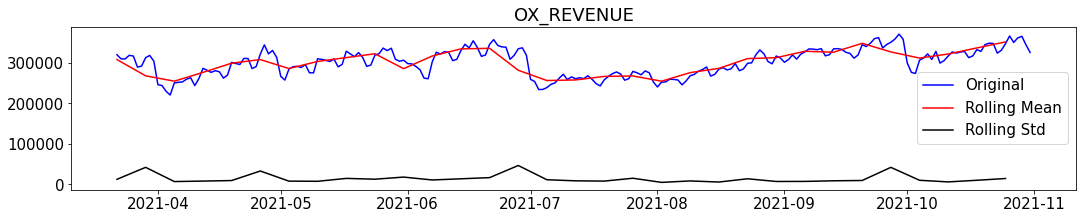

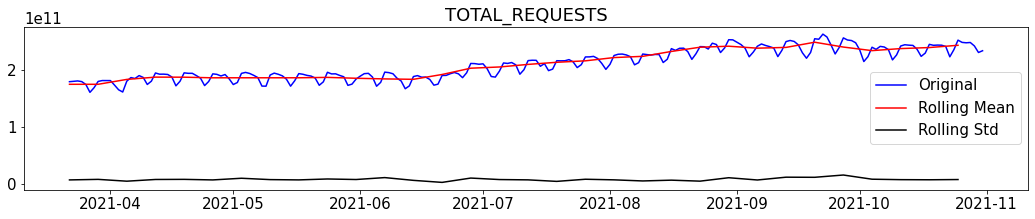

In [ ]:
# Resample the entire dataset by daily average
df_daily['ReportDay'] = pd.to_datetime(df_daily['ReportDay'])
df_test = df_daily[['ReportDay', 'OX_REVENUE', 'TOTAL_REQUESTS']]
df_test = df_test.set_index('ReportDay')
df_test.head()
rollmean = df_test.resample(rule='7D').mean()
rollstd = df_test.resample(rule='7D').std()

# Plot time series for each sensor with its mean and standard deviation
names = ["OX_REVENUE", 'TOTAL_REQUESTS'] 
for name in names:
    _ = plt.figure(figsize=(18,3))

    _ = plt.plot(df_test[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

In [ ]:
rollstd['OX_REVENUE'].head()

ReportDay
2021-03-22    12518.773535
2021-03-29    42048.891707
2021-04-05     6933.219688
2021-04-12     8101.901402
2021-04-19     9433.219200
Freq: 7D, Name: OX_REVENUE, dtype: float64

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
series = df_daily[['ReportDay','OX_REVENUE']]
series2 = df_daily[['ReportDay','OX_REVENUE']]
series = series.set_index('ReportDay')

<ipython-input-276-8c14b230683a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series2['anomaly_pc1'] = ((series2['OX_REVENUE']>upper_bound) | (series2['OX_REVENUE']<lower_bound)).astype('int')


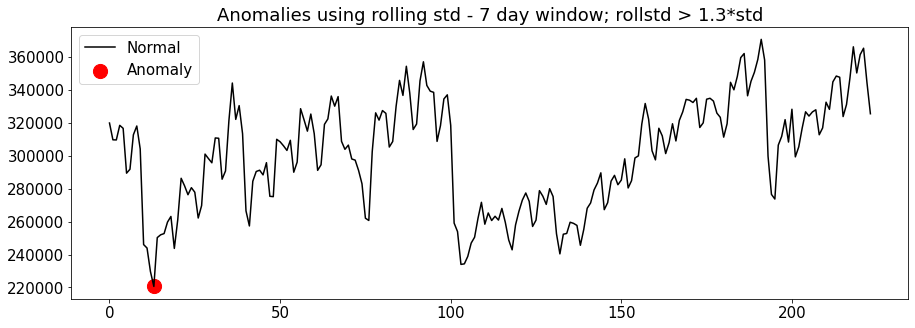

In [ ]:
from hana_ml.algorithms.pal.tsa.seasonal_decompose import seasonal_decompose

q1 = series2['OX_REVENUE'].quantile(0.25)
q3 = series2['OX_REVENUE'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 -(1.0 * iqr) 
upper_bound = q3 +(1.0 * iqr)

series2['anomaly_pc1'] = ((series2['OX_REVENUE']>upper_bound) | (series2['OX_REVENUE']<lower_bound)).astype('int')

series2.head()

fig, ax = plt.subplots(figsize=(15,5))
# 
b = series2.loc[series2['anomaly_pc1'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(series2.index, series2['OX_REVENUE'], color='black', label = 'Normal')

ax.scatter(b.index,b['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
plt.legend()
plt.title("Anomalies using rolling std - 7 day window; rollstd > 1.3*std")
plt.show()

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
series2['diff'] = differencing(series2, 'OX_REVENUE', 1)
series2.head()

<ipython-input-284-518f8bc8f2d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series2['diff'] = differencing(series2, 'OX_REVENUE', 1)


,ReportDay,OX_REVENUE,anomaly_pc1,diff
0,2021-03-22,319975,0,25.313901
1,2021-03-23,309772,0,-10203.000000
2,2021-03-24,309695,0,-77.000000
3,2021-03-25,318577,0,8882.000000
4,2021-03-26,316761,0,-1816.000000


<ipython-input-295-d1940db33993>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series2['anomaly'] = ((series2['diff']>upper_bound) | (series2['diff']<lower_bound)).astype('int')


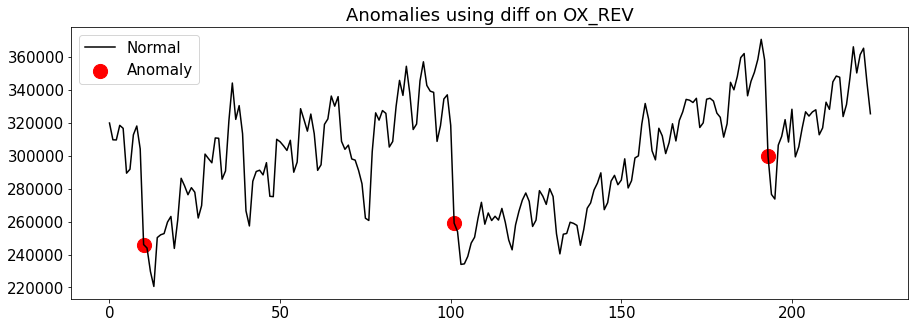

In [ ]:
q1 = series2['diff'].quantile(0.25)
q3 = series2['diff'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 -(3.0 * iqr) 
upper_bound = q3 +(3.0 * iqr)

series2['anomaly'] = ((series2['diff']>upper_bound) | (series2['diff']<lower_bound)).astype('int')

series2.head()

fig, ax = plt.subplots(figsize=(15,5))
# 
b = series2.loc[series2['anomaly'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(series2.index, series2['OX_REVENUE'], color='black', label = 'Normal')

ax.scatter(b.index,b['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
plt.legend()
plt.title("Anomalies using diff on OX_REV")
plt.show()

In [ ]:
an = series2[series2['anomaly']==1]
an.head()

,ReportDay,OX_REVENUE,anomaly_pc1,diff,anomaly,Min_SMA,SMA,Min_EMA
10,2021-04-01,246090,0,-58155.0,1,246628.647719,246628.647719,200540.254487
101,2021-07-01,259151,0,-59431.0,1,261103.125006,261103.125006,210903.523827
193,2021-10-01,299813,0,-58473.0,1,299748.487510,299748.487510,254205.058973


In [ ]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result


test_stationarity(series2['OX_REVENUE'], series=True)

'Non-Stationary'

In [ ]:
def predict_SMA(feature):
  window= 7
  sma = series2[feature].rolling(window=window).mean()
  rstd = series2[feature].rolling(window=window).std()
  bands = pd.DataFrame()
  bands['ReportDay']=  (series2['ReportDay']).copy()
  bands['ReportDay'] = pd.to_datetime(bands['ReportDay'], dayfirst=True)
  bands['sma'] = sma 
  bands['lower'] = sma - 2 * rstd
  bands['upper'] = sma + 2 * rstd
  bands = bands.join(series2[feature])
  bands = bands.set_index('ReportDay')
  fig = plt.figure(figsize=(20, 6))
  ax = bands.plot(title=feature,  figsize=(20, 6))
  ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
  ax.set_xlabel('ReportDay')
  ax.set_ylabel(feature)
  ax.grid()
  plt.show()
  return bands

<Figure size 1440x432 with 0 Axes>

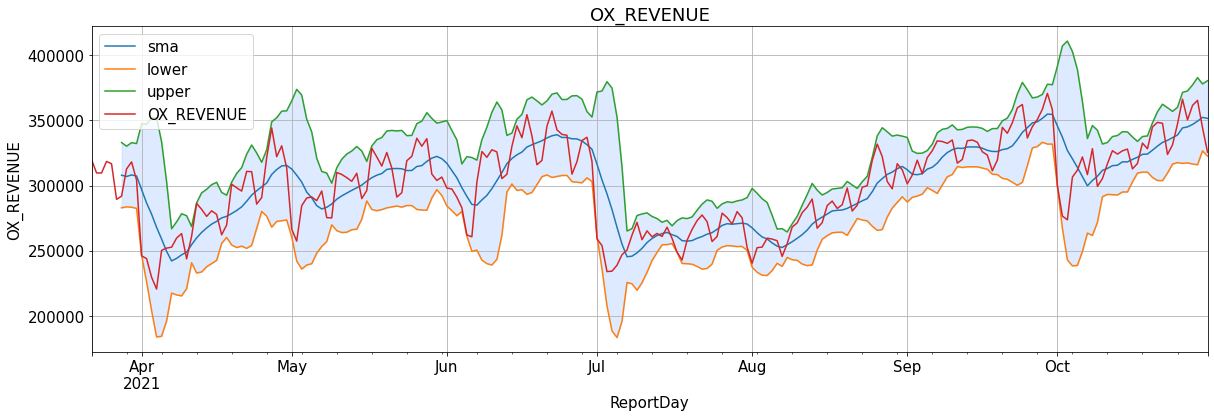

Anamolies for SMA_Min values
      ReportDay  OX_REVENUE            SMA
10  2021-04-01      246090  246628.647719
101 2021-07-01      259151  261103.125006


<ipython-input-319-ca5717feb680>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series2['SMA']= bands['lower'].copy()


In [ ]:
bands = predict_SMA('OX_REVENUE')
bands.reset_index(inplace=True)
min= series2['OX_REVENUE']
bands['lower'].fillna(min , inplace=True)
series2['SMA']= bands['lower'].copy()
print('Anamolies for SMA_Min values\n', series2[series2['OX_REVENUE']<series2['SMA']][['ReportDay','OX_REVENUE', 'SMA']])

<Figure size 1440x432 with 0 Axes>

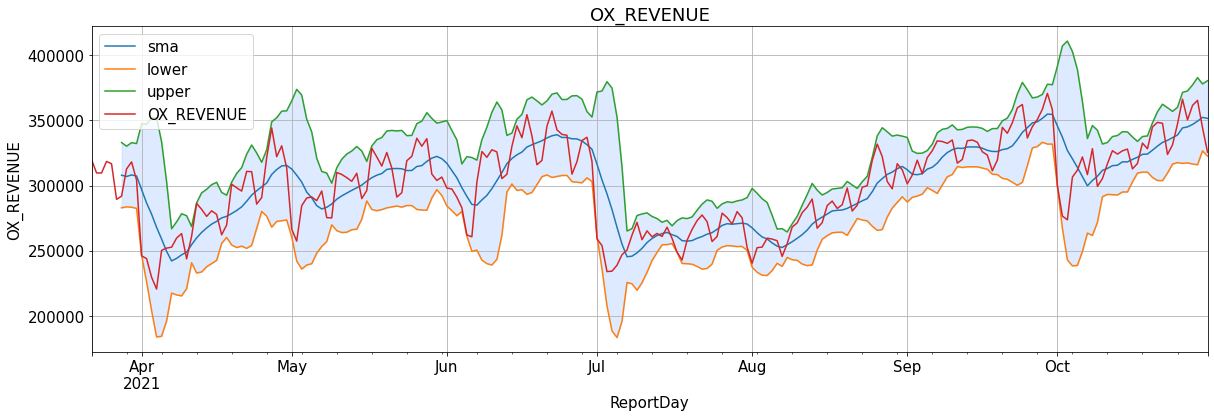

Anamolies for Max_SMA values
 Empty DataFrame
Columns: [ReportDay, OX_REVENUE, Max_SMA]
Index: []


In [ ]:
bands = predict_SMA('OX_REVENUE')
bands.reset_index(inplace=True)
max= df['OX_REVENUE'].max()
bands['upper'].fillna(max , inplace=True)

df['Max_SMA']= bands['upper'].copy()
print('Anamolies for Max_SMA values\n', df[df['OX_REVENUE']>df['Max_SMA']][['ReportDay','OX_REVENUE', 'Max_SMA']])

In [ ]:
def predict_EMA(feature):
  window= 3
  ema = series2[feature].ewm(span=window,adjust=False).mean()
  rstd = series2[feature].rolling(window=window).std()
  bands = pd.DataFrame()
  bands['ReportDay']=  (series2['ReportDay']).copy()
  bands['ReportDay'] = pd.to_datetime(bands['ReportDay'], dayfirst=True)
  bands['ema'] = ema 
  bands['lower'] = ema - 2 * rstd
  bands['upper'] = ema + 2 * rstd
  bands = bands.join(series2[feature])
  bands = bands.set_index('ReportDay')
  fig = plt.figure(figsize=(20, 6))
  ax = bands.plot(title=feature,  figsize=(20, 6))
  ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
  ax.set_xlabel('ReportDay')
  ax.set_ylabel(feature)
  ax.grid()
  plt.show()
  return bands

<Figure size 1440x432 with 0 Axes>

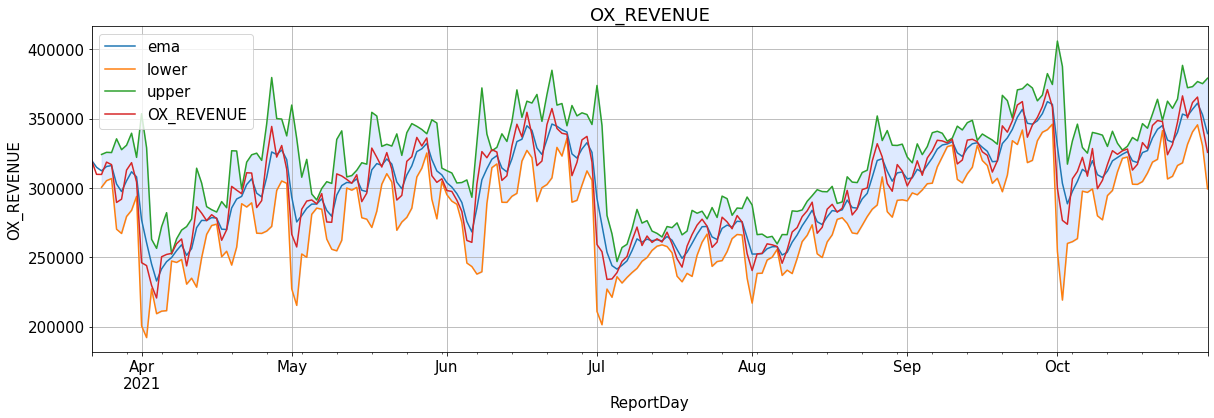

Anamolies for EMA_Min values
 Empty DataFrame
Columns: [ReportDay, OX_REVENUE, Min_EMA]
Index: []


<ipython-input-313-9c29c79f16b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series2['Min_EMA']= bands['lower'].copy()


In [ ]:
bands= predict_EMA('OX_REVENUE')
bands.reset_index(inplace=True)
min= series2['OX_REVENUE']
bands['lower'].fillna(min , inplace=True)
series2['Min_EMA']= bands['lower'].copy()
print('Anamolies for EMA_Min values\n', series2[series2['OX_REVENUE']<series2['Min_EMA']][['ReportDay','OX_REVENUE', 'Min_EMA']])

In [ ]:

# nan_s =series[series['OX_REVENUE'].isna()]
# nan_s.sum()
# len(df)
# df_daily.isna().sum()

result = seasonal_decompose(series, model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

ReportDay
2021-03-22              NaN
2021-03-23              NaN
2021-03-24              NaN
2021-03-25    308022.890085
2021-03-26    307001.158791
                  ...      
2021-10-27    352383.386026
2021-10-28    351580.343876
2021-10-29              NaN
2021-10-30              NaN
2021-10-31              NaN
Name: trend, Length: 224, dtype: float64
ReportDay
2021-03-22     4713.122502
2021-03-23     8658.905852
2021-03-24     7180.730725
2021-03-25     6547.291349
2021-03-26     4073.319078
                  ...     
2021-10-27     7180.730725
2021-10-28     6547.291349
2021-10-29     4073.319078
2021-10-30   -16880.109169
2021-10-31   -14293.260336
Name: seasonal, Length: 224, dtype: float64
ReportDay
2021-03-22            NaN
2021-03-23            NaN
2021-03-24            NaN
2021-03-25    4007.440541
2021-03-26    5687.421561
                 ...     
2021-10-27   -9140.976801
2021-10-28    3408.170412
2021-10-29            NaN
2021-10-30            NaN
2021-10-31          

<AxesSubplot:xlabel='ReportDay'>

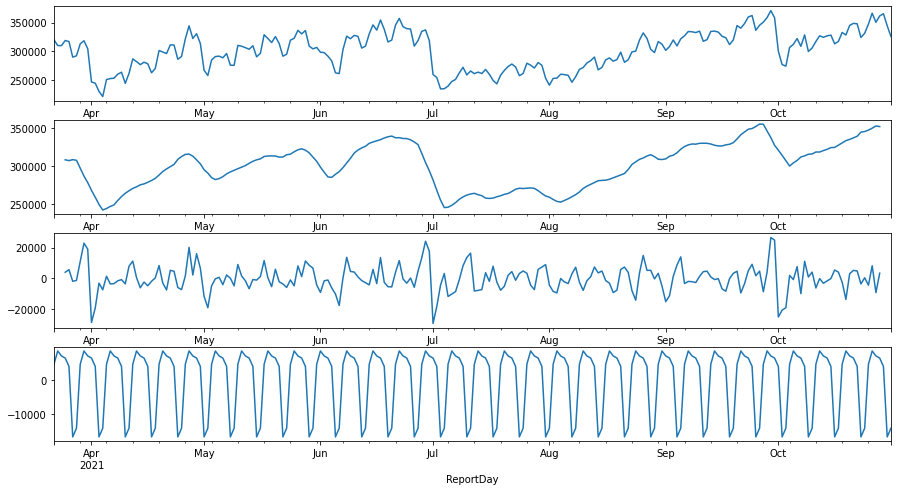

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.resid.plot(ax=ax3)
result.seasonal.plot(ax=ax4)

In [ ]:
series = df_daily[['ReportDay','OX_REVENUE']]
series = series.set_index('ReportDay')
# nan_s =series[series['OX_REVENUE'].isna()]
# nan_s.sum()
# len(df)
# df_daily.isna().sum()

result = seasonal_decompose(series, model='multiplicative')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

ReportDay
2021-03-22              NaN
2021-03-23              NaN
2021-03-24              NaN
2021-03-25    308022.890085
2021-03-26    307001.158791
                  ...      
2021-10-27    352383.386026
2021-10-28    351580.343876
2021-10-29              NaN
2021-10-30              NaN
2021-10-31              NaN
Name: trend, Length: 224, dtype: float64
ReportDay
2021-03-22    1.015929
2021-03-23    1.028630
2021-03-24    1.024089
2021-03-25    1.021398
2021-03-26    1.013642
                ...   
2021-10-27    1.024089
2021-10-28    1.021398
2021-10-29    1.013642
2021-10-30    0.944012
2021-10-31    0.952299
Name: seasonal, Length: 224, dtype: float64
ReportDay
2021-03-22         NaN
2021-03-23         NaN
2021-03-24         NaN
2021-03-25    1.012598
2021-03-26    1.017908
                ...   
2021-10-27    0.971046
2021-10-28    1.006773
2021-10-29         NaN
2021-10-30         NaN
2021-10-31         NaN
Name: resid, Length: 224, dtype: float64
ReportDay
2021-03-22    319975

<AxesSubplot:xlabel='ReportDay'>

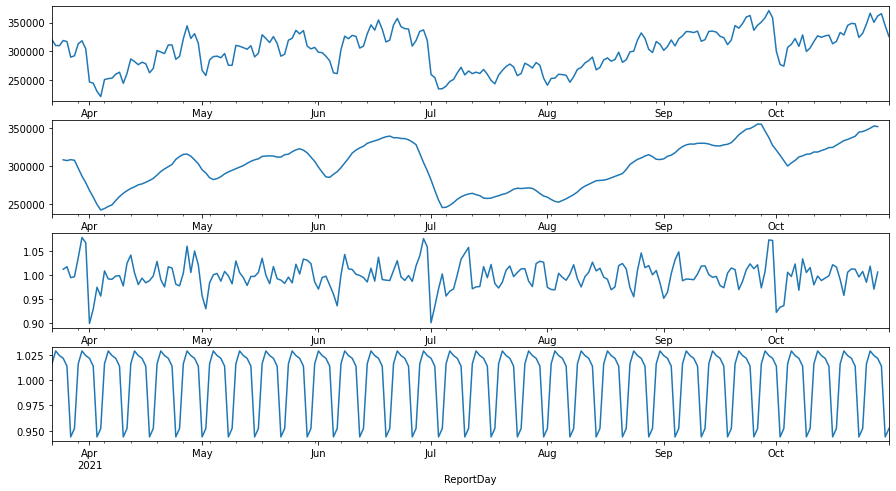

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.resid.plot(ax=ax3)
result.seasonal.plot(ax=ax4)


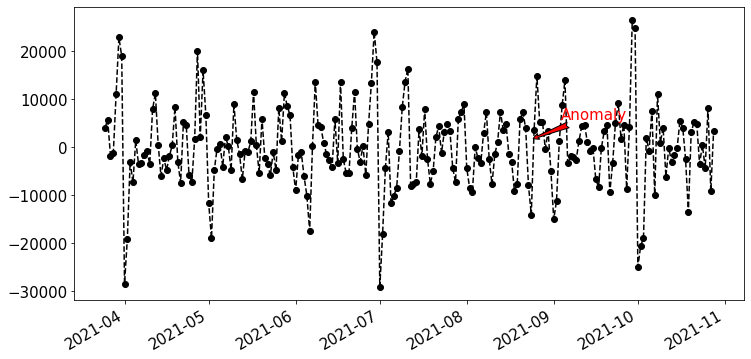

In [ ]:
import matplotlib.dates as mdates

plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')
ax.annotate('Anomaly', (mdates.date2num(x[155]), y[35]), xytext=(30, 20),
          textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
fig.autofmt_xdate()
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest
df_ox_rev = df_test[["OX_REVENUE"]]
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_ox_rev.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
# len(model.predict(data))
# len(df_ox_rev['OX_REVENUE'])
# len(data)
# df_ox_rev.head()

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

<ipython-input-202-885ab74f691a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ox_rev['anomaly'] = model.predict(data)


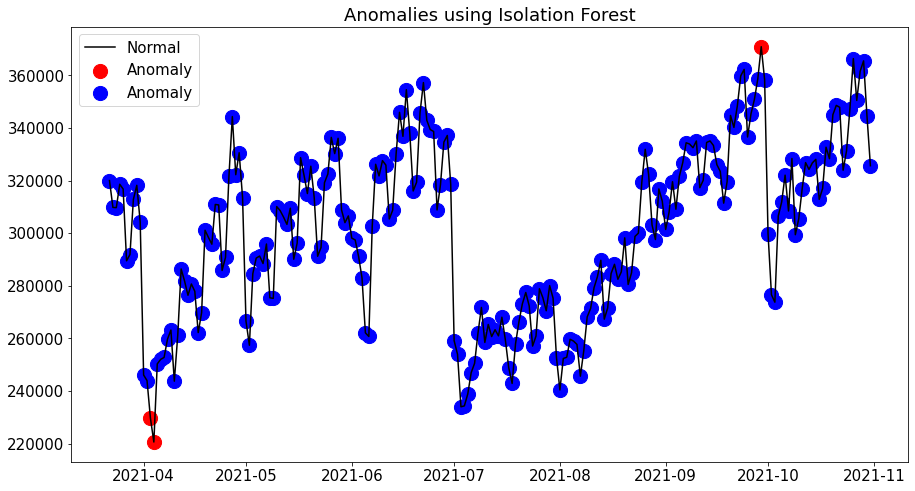

In [ ]:
df_ox_rev['anomaly'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(15,8))
a = df_ox_rev.loc[df_ox_rev['anomaly'] == -1, ['OX_REVENUE']] #anomaly
b = df_ox_rev.loc[df_ox_rev['anomaly'] == 1, ['OX_REVENUE']] #anomaly
ax.plot(df_ox_rev.index, df_ox_rev['OX_REVENUE'], color='black', label = 'Normal')
ax.scatter(a.index,a['OX_REVENUE'], color='red', label = 'Anomaly', s = 200)
ax.scatter(b.index,b['OX_REVENUE'], color='blue', label = 'Anomaly', s = 200)
plt.legend()
plt.title("Anomalies using Isolation Forest")
plt.show()

In [ ]:
!pip install fbprophet

     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=726620 sha256=1924ffa3289a37df5ba180dfc8bc368f22df8df9418dde353153554773a140f2
  Stored in directory: /Users/malwina.natkaniec/Library/Caches/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

prophet 1.0.1 requires cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
df_prophet = df_ox_rev.reset_index()
df_prophet = df_prophet[["ReportDay", "OX_REVENUE"]]
df_prophet["ReportDay"] = pd.to_datetime(df_prophet["ReportDay"])
df_prophet = df_prophet.rename(columns={"ReportDay":"ds", "OX_REVENUE":'y'})
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      224 non-null    datetime64[ns]
 1   y       224 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 KB


In [ ]:
def fit_predict_model(dataframe, interval_width = 0.95, changepoint_range = 0.8):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast
  
pred = fit_predict_model(df_prophet)

In [ ]:
def detect_anomalies(forecast):
   forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
   forecasted['anomaly'] = 0
   forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
   forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
   # anomaly importances
   forecasted['importance'] = 0
   forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
       (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
   forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
       (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
  
   return forecasted
pred = detect_anomalies(pred)

In [ ]:
import altair as alt

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='OX_REVENUE'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='OX_REVENUE'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

In [ ]:
!pip install pyod

In [ ]:
def outliers_detection(model, name):
    Y = df_prophet[["Y"]]
    clf = model
    clf.fit(Y)
    
    outliers = clf.predict(Y)
    
    Y_outliers = Y[np.where(outliers==1)]
    X_outliers = X[np.where(outliers==1)]
    
    Y_inliers = Y[np.where(outliers==0)]
    X_inliers = X[np.where(outliers==0)]
    print(X_outliers)
    
    
    plt.scatter(X_outliers, Y_outliers, edgecolor='black',color='red', label='outliers')
    plt.scatter(X_inliers, Y_inliers, edgecolor='black',color='green', label='inliers')
    plt.title(name)
    plt.legend()
    plt.grid()
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.show()
    
    anomaly_score = clf.decision_function(Y)
    min_outlier_anomaly_score = np.floor(np.min(anomaly_score[np.where(outliers==1)])*10)/10
    plt.hist(anomaly_score, bins=n_bins)
    plt.axvline(min_outlier_anomaly_score, c='k')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Number of data points')
    plt.show()
    return anomaly_score

In [ ]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

/Users/malwina.natkaniec/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/malwina.natkaniec/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/malwina.natkaniec/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function fo

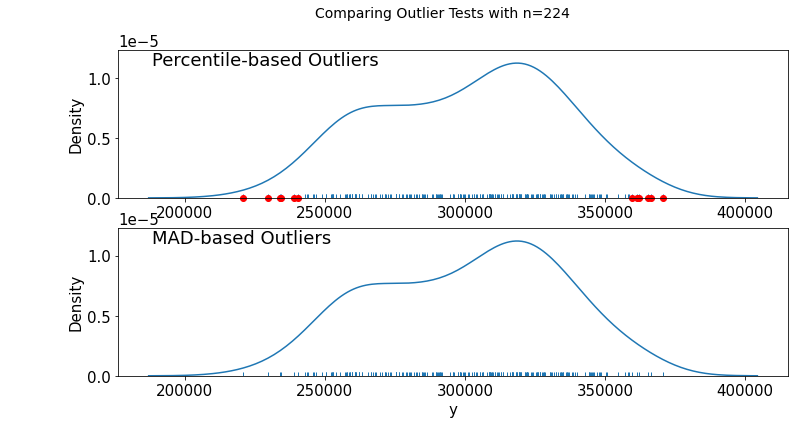

In [ ]:
def main():
    x=df_prophet['y']
    plot(x)

    plt.show()

def mad_based_outlier(points, thresh=3.0):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def plot(x):
    fig, axes = plt.subplots(nrows=2)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

main()